# EE4312 Project 2: *VAE and YOLOv11*
Due Date: 8 Apr 2025 (W12 Tue), 23:59

---

# 2 &emsp; The Variational Autoencoder

This project implements the variational autoencoder (VAE) using dense layers. This part of the project is adapted from https://keras.io/examples/generative/vae/ . While googling, please keep in mind that some code examples on the internet are outdated.

### Overview of Training
During the training process, the **encoder** in the VAE learns the parameters (mean, variance) of the *variational* (approximate) Gaussian distribution that an image is likely to come from. The parameters are used to generate a random encoding of the image. The random encoding is then passed into the **decoder** to reconstruct the image.

### Learning the Variational Distribution
With sampling, an image can have a range of encodings clustered around, but not exactly at, the mean of the variational distribution.
Over time, this forces the decoder to **learn to use the parameters of the distribution to reconstruct the images**, rather than the specific encoding of an image, to mimimize reconstruction errors.
Images that look similar will be clustered close to an encoded mean, while dissimilar images will be pushed further away from this encoded mean.
This results in the interpolation of images in the figure below.

### The VAE Loss
The loss of the VAE is the negative **Evidence Lower Bound (ELBO)**, which is the sum of the **reconstruction loss** and the **prior-matching loss**. The reconstruction loss is simply the loss between the reconstructed image and the original image, while the prior-matching loss ensures that the learnt parameters are as close to a standard Gaussian as possible.


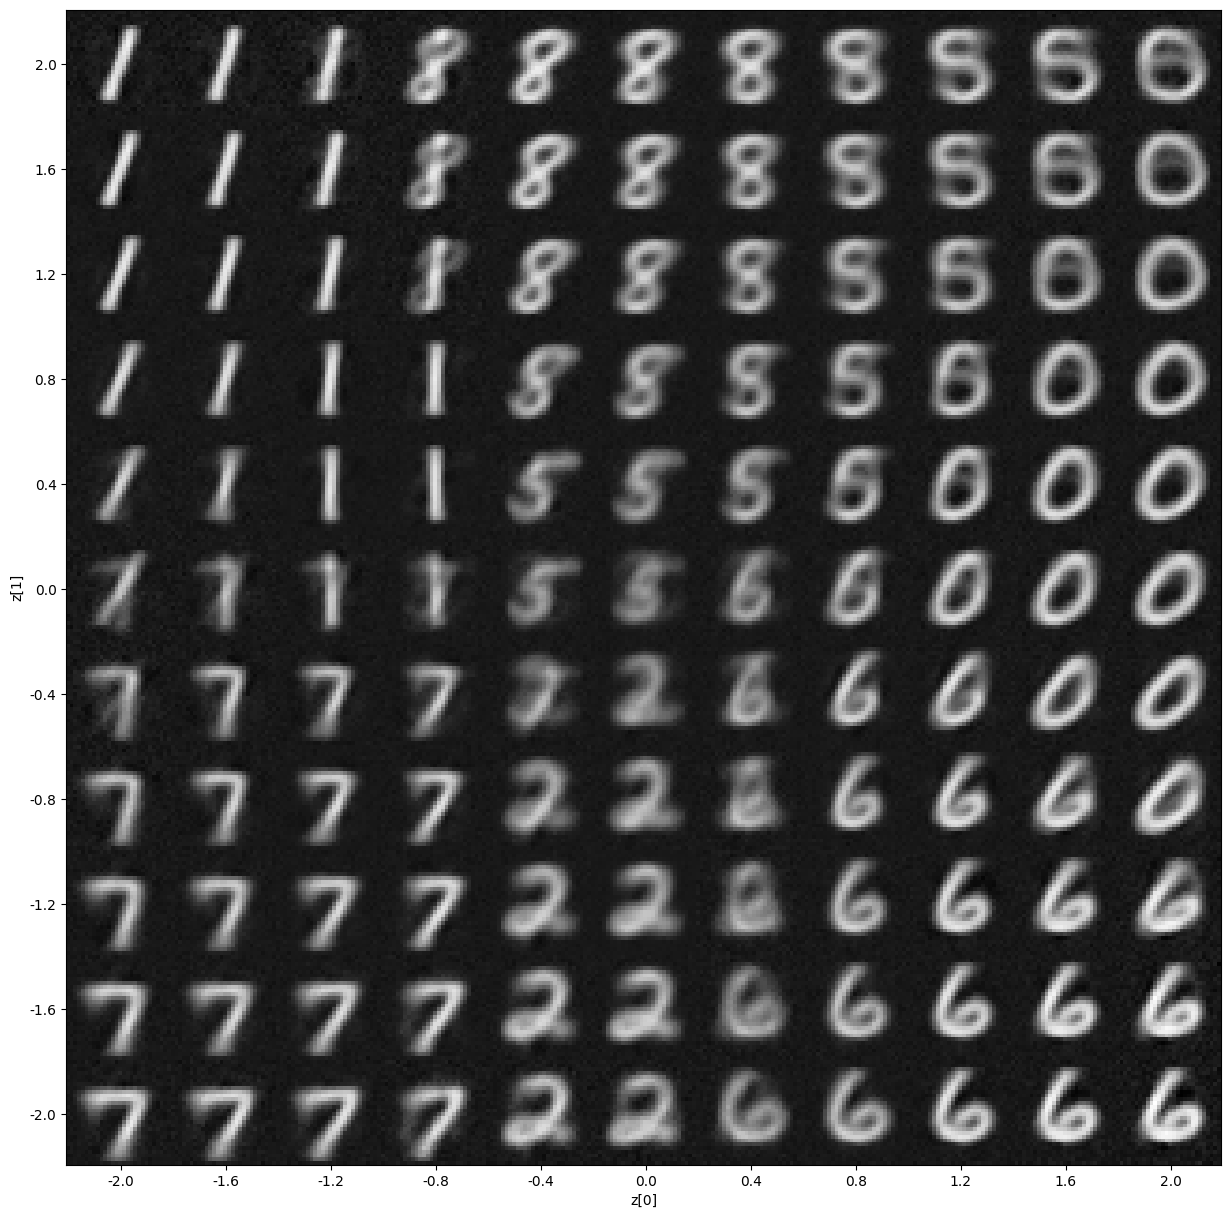

## 2.1 &emsp; Initialization
1. Replace the string in `matric_numbers` with your matric numbers.
2. Run the code block (`Ctrl+Enter`).

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Chosen Digits for MNIST classification:
	[0 1 2 3 4 6 9]
c_x_train Shape (num, dim1, dim2,): (49569, 28, 28)
c_y_train Shape (num,): (49569,)


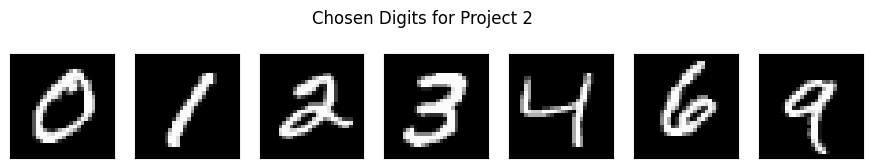

In [ ]:
matric_numbers = [  'A0250183M',    'A0233403W',    'A0255341L']
                #   RJ              JA              HR

######### Import libraries ###################
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import keras


########## Code to make training reproducible ##########
def makeSeed(matric_numbers):
  seed = 0;
  for i in range(len(matric_numbers)):
    seed += int(''.join(filter(str.isdigit, matric_numbers[i])))
  return seed

SEED = makeSeed(matric_numbers)

def makeReproducible():
  tf.keras.utils.set_random_seed(SEED)
  tf.config.experimental.enable_op_determinism()

########### Create Folders to store trained data #############
P2_FOLDER = 'data/proj2/'
!rm -rf $P2_FOLDER # this is not a valid python script, used only in colab
!mkdir -p $P2_FOLDER # this is not a valid python script, used only in colab

###### Constants ############
P2_NUM_DIGITS = 7

###### Variables to be initialized later, placed here for clarity ##########
p2_model = None
p2_expt_name = ''
p2_learning_rate = 0
p2_epochs = 0
p2_batch_size = 0
p2_elapsed = 0
p2_history = None
p2_encoder_dims = [] #Everything before the mean, log_var and sampling layers.
p2_decoder_dims = [] #Everything after the first layer
p2_latent_dim = []
p2_x_train = []
p2_y_train = []
p2_digits = []
p2_layer_flatten = None
p2_layer_norm = None
p2_beta = 1
# self additions
p2_optimizer_type = ''
p2_layer_type = ''

##### Initialize the variables ########
def init():
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  digits = np.sort(np.random.choice(np.arange(10), size=P2_NUM_DIGITS, replace=False))
  print(f'Chosen Digits for MNIST classification:\n\t{digits}')

  selected_train_idx = np.full(shape=y_train.shape, fill_value=0, dtype=bool)
  selected_test_idx = np.full(shape=y_test.shape, fill_value=0, dtype=bool)
  for digit in digits:
    selected_train_idx = selected_train_idx | (y_train == digit)
    selected_test_idx = selected_test_idx | (y_test == digit)

  # store the chosen images
  x_train = x_train[selected_train_idx]
  y_train = y_train[selected_train_idx]
  x_test = x_test[selected_test_idx]
  y_test = y_test[selected_test_idx]

  # concatenate
  x_train = np.concatenate([x_train, x_test], axis=0).astype("float32")/255
  y_train = np.concatenate([y_train, y_test], axis=0)

  return digits, x_train, y_train

##### Plot the Task #######
def plotTask():
  fig, axes = plt.subplots(ncols = P2_NUM_DIGITS, nrows=1, figsize=(11,2))
  fig.suptitle('Chosen Digits for Project 2')
  for i in range(P2_NUM_DIGITS):
    digit = p2_digits[i]
    axes[i].imshow(p2_x_train[np.argmax(p2_y_train == digit)], cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  print(f'c_x_train Shape (num, dim1, dim2,): {p2_x_train.shape}')
  print(f'c_y_train Shape (num,): {p2_y_train.shape}')


##### Run the functions ##########
makeReproducible() # call this everytime to 'reset' the random number generator and make subsequent random calls reproducible.
p2_digits, p2_x_train, p2_y_train = init()
plotTask()

## 2.2 &emsp; Sampling Layer

This is a custom layer to implement the **reparameterization trick** of the VAE.
It acts like it is outputing a random sample that is drawn from the Gaussian distribution parameterized by the learnt means and variances of the encoder.

In this layer, the encoded means $\mathbf{\mu}$ and log variances $\log\mathbf{\sigma}^2$ are applied to the standard Gaussian to output sampled latent values $\mathbf{z}$:

$$
\begin{align}
  \mathbf{z} &= \mathbf{\mu} + \mathbf{\sigma} \bigodot \mathbf{\epsilon}
\end{align}
$$
where $\bigodot$ denotes element-wise multiplication. This step is part of the **reparameterization trick**, which allows a random distribution to be sampled without causing problems for back-propagation. All of the variables above are $n\times p$ matrices, where $n$ is the size of the batch, and $p$ is the number of latent variables.

Here, we design the custom sampling layer `Sampling`'s `call` function.
1. `inputs` is a Python list of Keras tensors (or linked layers). The list contains $\mathbf{\mu}$ as `z_mean`, and $\log(\sigma^2)$ as `z_log_var`.
  ```python
    z_mean, z_log_var = inputs
  ```

2. By reading the shape of the inputs, determine the batch size $n$ as `batch`, and the number of latent variables $p$ as `latent_dim`:
  ```python
    batch = keras.ops.shape(z_mean)[?] #'?' is first or second index
    latent_dim = keras.ops.shape(z_mean)[?] #'?' is first or second index
  ```
  While it is possible to just use `p2_batch_size`, there is less room for bugs if the batch size is calculated from the input.
  Hint: as mentioned above, all matrix sizes here are $n\times p$.

3. Next, calculate $n \times p$ standard Gaussian samples $\mathbf{\epsilon}$ and store them in `espilon`:
  ```python
    epsilon = keras.random.normal(shape=(?, ?), seed=self.rng) # determine (?, ?) using `batch` and `latent_dim`
  ```

4. Finally, return the samples $\mathbf{z}$ in `z`.
  ```python
    z = z_mean + ??? #keras.ops.exp(), z_log_var, epsilon
  ```
  Hint: $\sigma = e^{\log(\sigma)} = e^{0.5\log(\sigma^2)}$, and use `keras.ops.exp()`. Element-wise multiplication is simply `*`.

In [ ]:
class Sampling(keras.layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.rng = keras.random.SeedGenerator(SEED)

  def call(self, inputs):
    # (1)
    z_mean, z_log_var = inputs
    # (2)
    batch = keras.ops.shape(z_mean)[0] #'?' is first or second index
    latent_dim = keras.ops.shape(z_mean)[1] #'?' is first or second index
    # (3)
    epsilon = keras.random.normal(shape=(batch, latent_dim), seed=self.rng) # determine (?, ?) using `batch` and `latent_dim`
    # (4)
    z = z_mean + keras.ops.exp(0.5 * z_log_var) * epsilon #keras.ops.exp(), z_log_var, epsilon

    return z

## 2.3 &emsp; Encoder
The encoder accepts a $28\times28$ image input, and outputs $p$ latent variables. Note that the sampling layer is the last layer of the encoder.

The encoder is implemented in the function `buildEncoder()`. Follow the steps below to build the encoder.
1. Input layer that has a shape of $28\times 28$ neurons.
  ```python
    layer_input = ??? # input layer with (28, 28) shape.
  ```
2. Flatten layer to $784$ neurons.
  ```python
    layer_flatten = ??? # flatten layer.
  ```
3. Dense hidden layers dynamically generated based on `p2_encoder_dims`. If `p2_encoder_dims` is `[64,32]`, there are two hidden layers and the 1st and 2nd hidden layer have 64 and 32 neurons respectively. If `[32]`, there is one hidden layer and it has 32 neurons. Remember to choose an appropriate non-linear activation.
  ```python
  # # You may choose to implement:
  # layers = []
  # for num_hidden in p2_encoder_dims:
  #  ??? # dense layer. Don't forget the activations.
  ```
4. Two side-by-side layers. If there are $p$ (`p2_latent_dim`) latent dimensions,
  - A layer with $p$ neurons, each neuron outputing the *mean*.
  - A layer with $p$ neurons, each neuron outputing *variance*.
  ```python
    layer_mean = ??? # p2_latent_dim. Dense layer with linear activation.
    layer_variance = ??? # p2_latent_dim. Dense layer with linear activation.
  ```
5. The aforementioned *sampling layer* with $p$ neurons, to transform a random sample from the standard Gaussian using the output *mean* and *variance*.
  ```python
    layer_sampling = Sampling()
  ```

6. Link the layers in the order above:
  ```python
  out = layer_flatten(layer_input)
  out = ??? # the hidden layers
  z_mean = layer_mean(out)
  z_log_var = layer_mean(out)
  z = layer_sampling((z_mean, z_log_var))
  ```

7. Initialize the model, and summarize.
  ```python
  encoder = keras.Model(???, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  ```
  Notice that there are three outputs: `z_mean`, `z_log_var` and `z`. The first two are required to calculate the prior-matching loss, while `z` is passed into the decoder.

The function then returns the `encoder`.

In [ ]:
def buildEncoder():
  # (1) to (7)
  if p2_layer_type == 'CNN': # convolutional layers
    layer_input = keras.Input(shape=(28,28,1))
    out = layer_input

    # convolutional hidden layers
    for num_filters in p2_encoder_dims:
        out = keras.layers.Conv2D(num_filters, 3, strides=2, padding='same', activation='relu')(out) # hardcoded other variables based on documentation
    out = keras.layers.Flatten()(out)

  else: # dense layers
    layer_input = keras.Input(shape=(28,28)) # input layer with (28, 28) shape.
    layer_flatten = keras.layers.Flatten()(layer_input)

    out = layer_flatten

    for num_hidden in p2_encoder_dims:
        out = keras.layers.Dense(num_hidden, activation='relu')(out)

  z_mean = keras.layers.Dense(p2_latent_dim, activation='linear', name='z_mean')(out)
  z_log_var = keras.layers.Dense(p2_latent_dim, activation='linear', name='z_log_var')(out)

  layer_sampling = Sampling()
  z = layer_sampling((z_mean, z_log_var))

  encoder = keras.Model([layer_input], [z_mean, z_log_var, z], name="encoder")
  encoder.summary()

  return encoder

## 2.4 &emsp; Decoder

The decoder accepts $p$ latent input, and outputs $28\times28$ reconstructed image.
The decoder is implemented in the function `buildDecoder()`.

1. Input layer with $p$ (`p2_latent_dim`) neurons.
  ```python
  layer_input = ??? # has p2_latent_dim inputs.
  ```
2. Dense hidden layers dynamically generated based on `p2_decoder_dims`. The code is similar to the encoder's dynamically generated hidden layers.
  ```python
  # # You may choose to implement:
  # layers = []
  # for num_hidden in p2_decoder_dims:
  #  ??? # dense layer. Don't forget the activations.
  ```

3. An output layer that has 784 neurons, and with activations depending on the *reconstruction loss* used.
  ```python
  layer_output = keras.layers.Dense(???, activation=???)
  ```
  The reconstruction loss is MSE, binary cross-entropy, etc.

4. A reshape layer to $28\times 28$ neurons.
  ```python
  layer_reshape = ??? # The tuple (28,28) is to be used.
  ```

5. Link the layers
  ```python
  out = layer_input
  out = ??? # hidden layers
  out = ??? # reshape layer, output layer
  ```

6. Initialize the model and summarize:
  ```python
  decoder = keras.Model(???, [out], name="decoder")
  decoder.summary()
  ```

The function then returns the `decoder`.

In [ ]:
def buildDecoder():
  # (1) to (6)
  layer_input = keras.layers.Input(shape=(p2_latent_dim,))
  out = layer_input

  if p2_layer_type == 'CNN':
    # from hardcoded stride + filter size, dimensions of last encoding layer is 28 // 2**number of encoding layers
    dims = 28 // (2**len(p2_encoder_dims))
    out = keras.layers.Dense(dims * dims * p2_decoder_dims[0], activation='relu')(out)
    out = keras.layers.Reshape((dims, dims, p2_decoder_dims[0]))(out)
    for num_filters in p2_decoder_dims:
        out = keras.layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', activation='relu')(out)
    # could add stuff to handle case where it doesn't conv back to 28x28, but i think as long as same number of conv layers it should be fine?
    out = keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid')(out) # output layer, sigmoid with binary cross entropy
    out = keras.layers.Reshape((28,28))(out)

  else:
    for num_hidden in p2_decoder_dims:
        out = keras.layers.Dense(num_hidden, activation='relu')(out)

    out = keras.layers.Dense(784, activation='sigmoid')(out) # output layer, sigmoid with binary cross entropy
    out = keras.layers.Reshape((28,28))(out) # reshape layer

  decoder = keras.Model([layer_input], [out], name="decoder")
  decoder.summary()

  return decoder

## 2.5 &emsp; Combining Encoder and Decoder

The class `VariationalAutoEncoder` implements a custom model of our VAE.

1. The `__init__()` function occurs when the model is first initialized, like how the layers were all initialized before the layers are linked in the previous sections.

  In this function, initialize and store the encoder and decoder models:
  ```python
  self.encoder = ??? # use the build...() function from above.
  self.decoder = ??? # use the build...() function from above.
  ```

2. `call()` occurs during the linking process (the first call), and when the model is being run (subsequent calls). There are internal methods to differentiate between the first and subsequent calls.

  1. Here, we link the encoder and decoder models
  ```python
  z???, z_log_var???, z_mean??? = self.encoder(inputs) # Determine if `z_mean`, `z_log_var`, and `z` is in the correct order by referencing the URL or by reasoning from buildEncoder()
  reconstructed = self.decoder(???) # reconstructed from ?
  ```

  2. Next we find the **prior-matching loss**, a.k.a. *KL divergence loss* or the *regularization term* for VAE.
  The loss is $\frac{1}{n}KL\left( q _ \phi(z \mid x) \; \lVert \; p(z) \right)$, which is always positive.
  It is small if the variational distribution learnt by the **encoder**, with probability $ q _ \phi(z\mid x) $, is close to the standard Gaussian with probability $p(z)$. Its derived form is given by:
  $$
    \begin{aligned}
    \frac{1}{n}KL\left( q _ \phi(z \mid x) \; \lVert \; p(z) \right) &=
      -\frac{1}{2n} \sum_{i=0}^{n} \left(
        \log (\sigma_i^2) + 1 - \sigma_i^2 - \mu_i^2
      \right)
    \end{aligned}
  $$
  ```python
    kl_loss = -0.5 * keras.ops.mean(???) # use z_log_var, keras.ops.exp(), and keras.ops.square().
  ```

  3. Find the **reconstruction loss** between `inputs` and `reconstructed`.
  We find the reconstruction loss by using either MSE or binary cross-entropy, or otherwise. If MSE is used, the function `keras.losses.mean_squared_error()` instead of the class `keras.losses.MeanSquaredError()` has to be used (see https://keras.io/api/losses/). The same applies for other losses.
  
    In addition, keep in mind that `inputs` and `reconstructed` are $n \times 28 \times 28 $ matrices. To find a scalar loss value, the flattened $n \times 784$ copies of the variables should be passed to the function:
    ```python
      reconstruction_loss = keras.losses.???(
        keras.ops.reshape(inputs, (-1, ???)),
        keras.ops.reshape(reconstructed, (-1, ???))
      )
    ```

  4. Sum the reconstruction and prior-matching losses, using the parameter `p2_beta` to scale the prior-matching loss like a regularization term. This may be necessary since both losses may not be at the same scale.
  ```python
    total_loss = reconstruction_loss + p2_beta * kl_loss
    self.add_loss(total_loss)
  ```

3. In `buildModel()`, using SGD with `p2_learning_rate`:
  ```python
  p2_model = VariationalAutoEncoder()
  optimizer = ??? # For now, use SGD with p2_learning rate
  p2_model.compile(optimizer) # notice that loss is not included, as it is already specified in the model.
  ```

In [ ]:
class VariationalAutoEncoder(keras.Model):
  def __init__(self, **kwargs):
    super().__init__(name="autoencoder", **kwargs)

    # (1)
    self.encoder = buildEncoder()
    self.decoder = buildDecoder()

# # copied from documentation, loss tracking --
#     self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
#     self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
#     self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

#   \@property
#   def metrics(self):
#     return [
#       self.total_loss_tracker,
#       self.reconstruction_loss_tracker,
#       self.kl_loss_tracker
#     ]
# # --

  def call(self, inputs):
    # (2.1) to (2.4)
    z_mean, z_log_var, z = self.encoder(inputs) # Determine if `z_mean`, `z_log_var`, and `z` is in the correct order by referencing the URL or by reasoning from buildEncoder()
    reconstructed = self.decoder(z)

    kl_loss = -0.5 * keras.ops.mean(z_log_var + 1 - keras.ops.exp(z_log_var) - keras.ops.square(z_mean))
    reconstruction_loss = keras.losses.binary_crossentropy(
      keras.ops.reshape(inputs, (-1, 784)),
      keras.ops.reshape(reconstructed, (-1, 784))
    )

    total_loss = reconstruction_loss + p2_beta * kl_loss
    self.add_loss(total_loss)

# # copied from documentation, loss updating --
#     self.total_loss_tracker.update_state(total_loss)
#     self.reconstruction_loss_tracker.update_state(reconstruction_loss)
#     self.kl_loss_tracker.update_state(kl_loss)
# # --

    return reconstructed

def buildModel():
  # (3)
  p2_model = VariationalAutoEncoder()
  if p2_optimizer_type == 'SGD':
    optimizer = keras.optimizers.SGD(learning_rate=p2_learning_rate) # For now, use SGD with p2_learning rate
  elif p2_optimizer_type == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=p2_learning_rate)
  p2_model.compile(optimizer) # notice that loss is not included, as it is already specified in the model.
  return p2_model

## 2.6 &emsp; Model Training
Using `p2_x_train`, `p2_batch_size`, and `p2_epochs`, implement:
```python
  p2_history = p2_model.fit(???,
                          ???,
                          validation_split=0,
                          verbose=1,
                          batch_size=???,
                          epochs=???,
                          shuffle=True, # True is the default value.
                          )
```
Keep in mind that the purpose of the VAE is to *reconstruct* the original image.

In [ ]:
def trainModel():

  ########### Train the Model #########
  print(f'    Experiment: {p2_expt_name}\nEncoder Dims: {p2_encoder_dims}\nLatent Dim: {p2_latent_dim}\nDecoder Dims: {p2_decoder_dims}\nBeta: {p2_beta}\n Learning Rate: {p2_learning_rate}\n        Epochs: {p2_epochs}\n    Batch Size: {p2_batch_size}')
  p2_elapsed = time.time()

  # (1)
  p2_history = p2_model.fit(p2_x_train,
                          p2_x_train,
                          validation_split=0,
                          verbose=1,
                          batch_size=p2_batch_size,
                          epochs=p2_epochs,
                          shuffle=True, # True is the default value.
                          )

  p2_elapsed = time.time() - p2_elapsed

  ########### Save the model ###########
  p2_model.save(f'{P2_FOLDER}/{p2_expt_name}.keras')
  print(f'Trained Model saved to {P2_FOLDER}/{p2_expt_name}.keras')

#   print(p2_history.history.keys())
  return p2_model, p2_history, p2_elapsed

## 2.7 &emsp; Analyze Model
Nothing to do here. Just run the code. The function outputs data, and plots generated images if there are two latent dimensions.

**Investigate** the function to see how the images are generated.

In addition, if you need a picture with extended `scale` or more pictures `n` along each of the two latent dimensions, you can re-run this function later after training is done.

In [ ]:
def analyzeModel(n = 11, scale = 2.0, suffix = ""):
  # only works for two latent dimensions.

  #### Write to text file ####
  p2_history_loss = p2_history.history['loss']
#   # other losses --
#   p2_reconstruction_loss = p2_history.history['reconstruction_loss']
#   p2_kl_loss = p2_history.history['kl_loss']
#   p2_total_loss = p2_history.history['total_loss']

#   # --
  tmp = open(f'{P2_FOLDER}/{p2_expt_name}.txt', 'w')
  out = ''
  out += f'Experiment\t{p2_expt_name}\n'
  out += f'EncoderDims\t{p2_encoder_dims}\n'
  out += f'LatentDim\t{p2_latent_dim}\n'
  out += f'DecoderDims\t{p2_encoder_dims}\n'
  out += f'Beta\t{p2_beta}\n'
  out += f'Learning Rate\t{p2_learning_rate}\n'
  out += f'Epochs\t{p2_epochs}\n'
  out += f'Batch\t{p2_batch_size}\n'
  out += f'Elapsed(s)\t{p2_elapsed}\n'
  for i in range(1, 11):
    out += f'Moving Average Loss ({i}0% Epoch)\t{p2_history_loss[int(0.1 * i * len(p2_history_loss) - 1)]}\n'
#   # other losses --
#   out += f'Reconstruction Loss\t{p2_reconstruction_loss[-1]}\n'
#   out += f'KL Loss\t{p2_kl_loss[-1]}\n'
#   out += f'Total Loss\t{p2_total_loss[-1]}\n'
#   # --

  tmp.write(out)
  tmp.close()
  print(out)

  if p2_latent_dim != 2:
    return

  # Plot images in latent space
  figsize = 15
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  p = 0
  for i, yi in enumerate(grid_y):
    p = p + n
    print(f'Generating {p} of {n*n}')
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = p2_model.decoder.predict(z_sample, verbose=0)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[
          i * digit_size : (i + 1) * digit_size,
          j * digit_size : (j + 1) * digit_size,
      ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()
  plt.savefig(f'{P2_FOLDER}/{p2_expt_name}_latent_{suffix}.png')

## 2.8 &emsp; Run Experiments
For first-time tuning:
- Keep the number of latent dimensions to 2, so that we can plot the generated images.
- Keep the number of batches at 128.
- Keep the number epochs at 20.
- Keep the number of hidden neurons in the encoder and decoder fixed.
- The learning rate may be unstable, and can be reduced.
- The beta value affects the scale of the prior-matching loss.

The learning rate and beta values have a huge impact on the final result. Observe the patterns first before changing the other hyperparameters.

If a clearer view of the images generated at different values along the latent dimensions, the `analyzeModel()` can be re-run *after training* with different arguments.

====================== START OF EXPT beta_0.001, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 196)            │        153,860 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.001, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.001
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 42.3512
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 28.7169
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 27.3576
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 26.6242
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 26.2317
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 25.9771
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 25.7051
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 25.5956
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 25.4000
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 25.4002
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 25.2552
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 25.1577
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 25.1551
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 25.0552
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


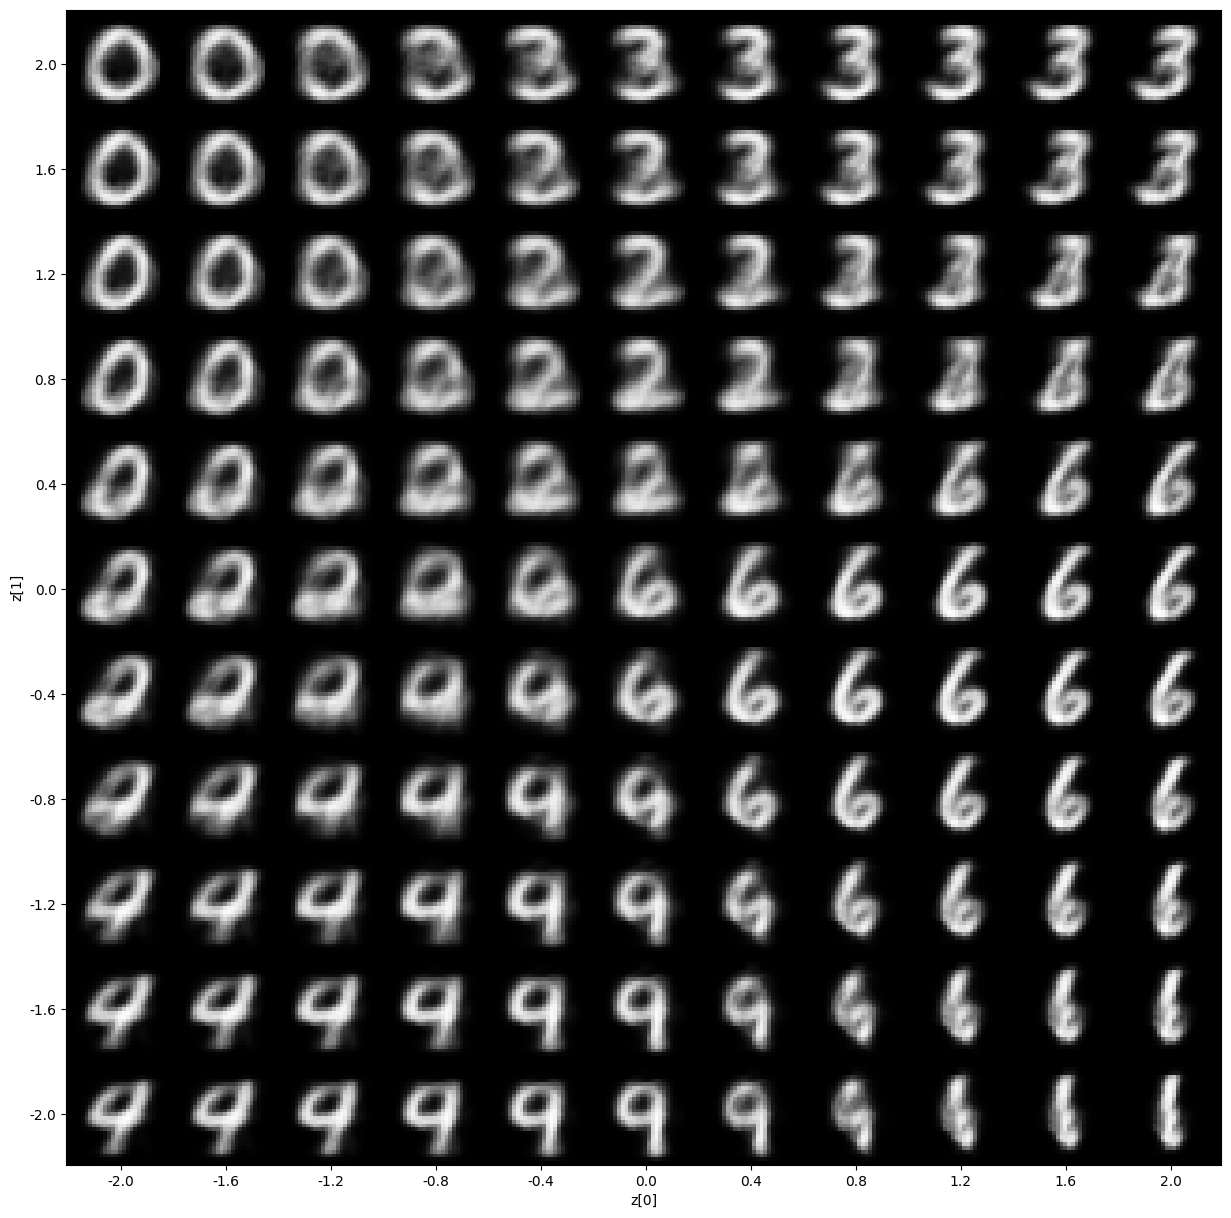

====================== END OF EXPT beta_0.001, lr_0.1 ======================================
====================== START OF EXPT beta_0.002, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 784)            │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 196)            │        153,860 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 43.5031
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 30.2209
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 28.5171
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 27.5348
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 27.0536
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 26.7818
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 26.5911
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 26.3778
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 26.2817
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 26.1696
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 25.9957
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 25.8866
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 25.8105
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 25.7604
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

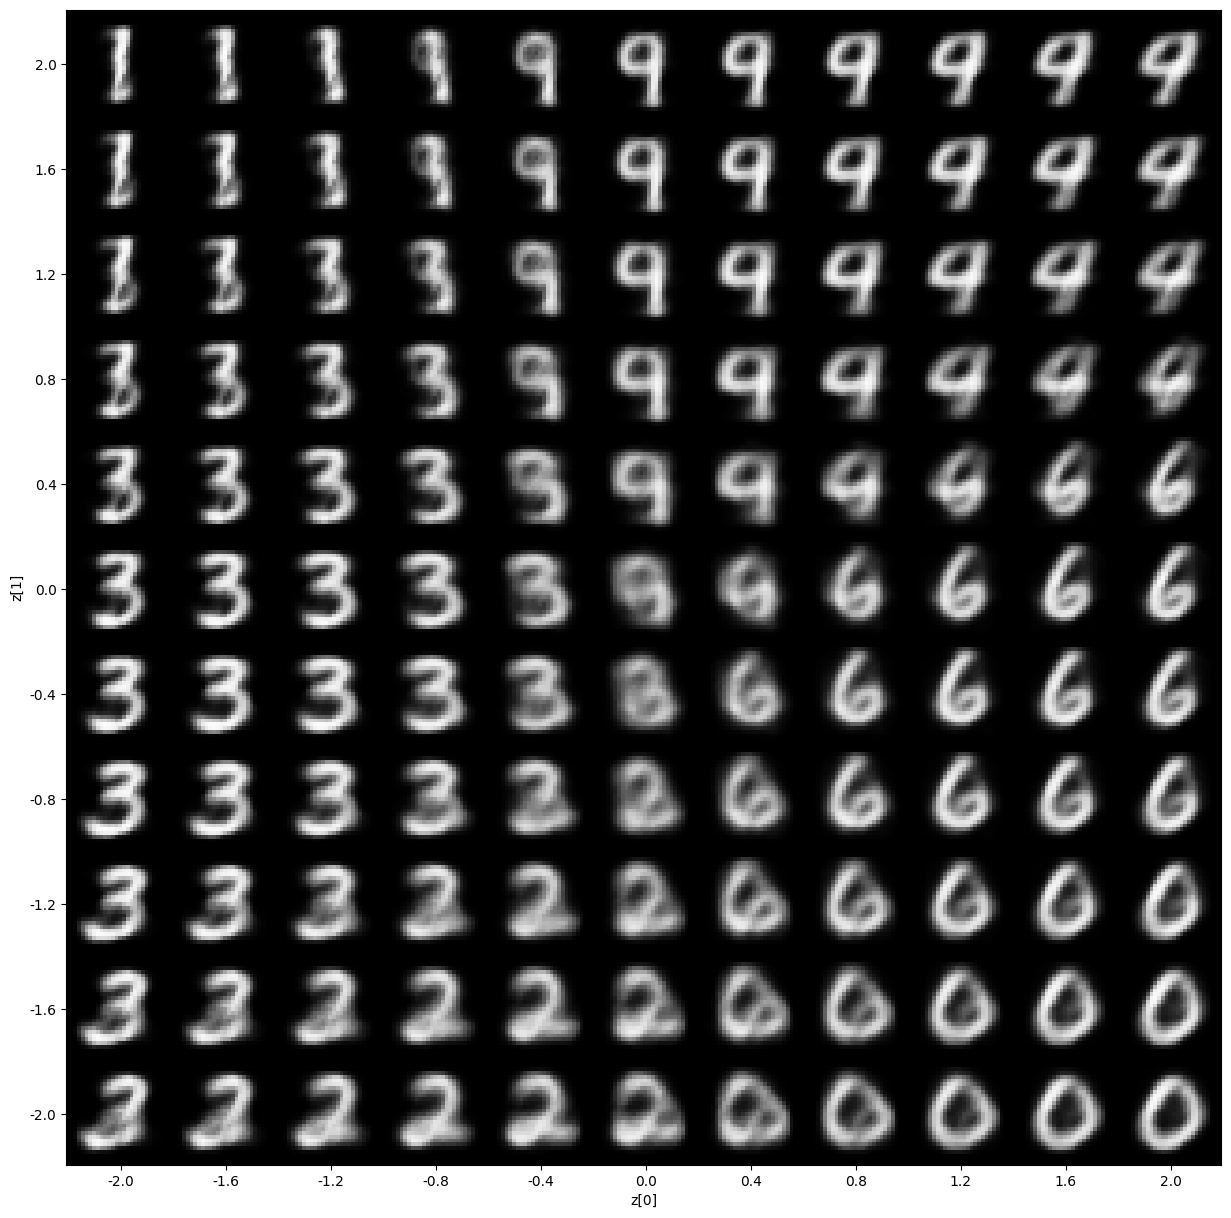

====================== END OF EXPT beta_0.002, lr_0.1 ======================================
====================== START OF EXPT beta_0.003, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 784)            │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 196)            │        153,860 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.003, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.003
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_20']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 49.0139
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 31.4266
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 30.1044
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 29.4574
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 28.3992
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 27.7399
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 27.3736
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 27.1816
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 27.0951
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 27.0201
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 26.9736
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 26.8707
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 26.8361
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 26.7990
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

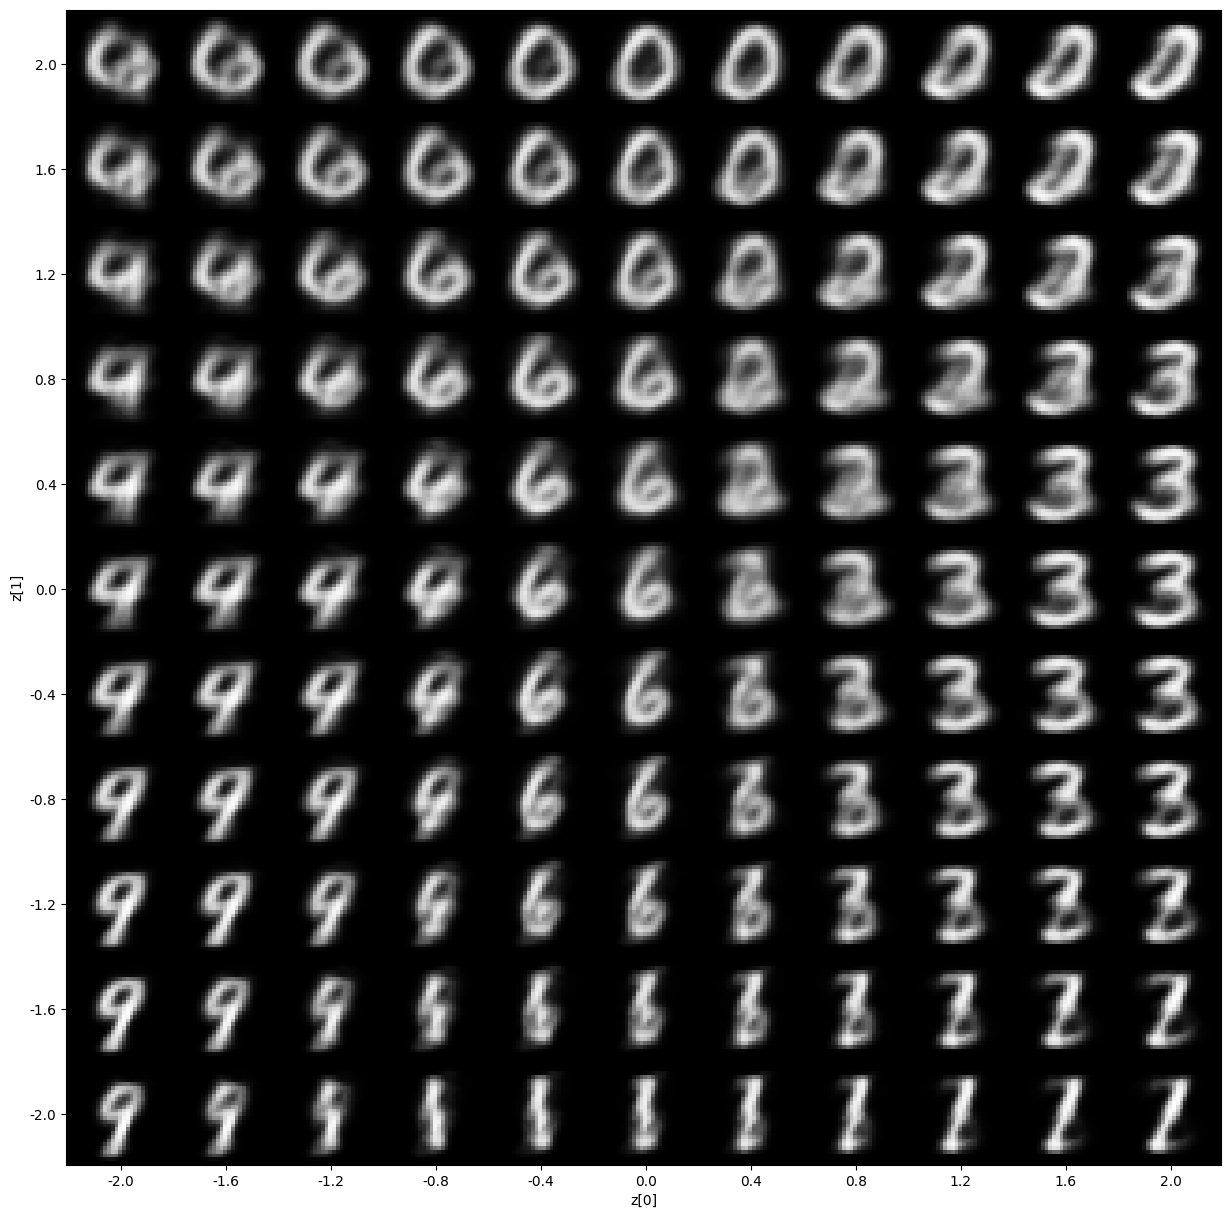

====================== END OF EXPT beta_0.003, lr_0.1 ======================================
====================== START OF EXPT beta_0.004, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 784)            │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 196)            │        153,860 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_3 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.004, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.004
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_30']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 43.5372
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 30.6905
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 29.1537
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 28.3571
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 27.9033
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 27.6642
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 27.4409
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 27.3149
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 27.2344
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 27.1333
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 27.0792
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 26.9493
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 26.9456
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 26.9144
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

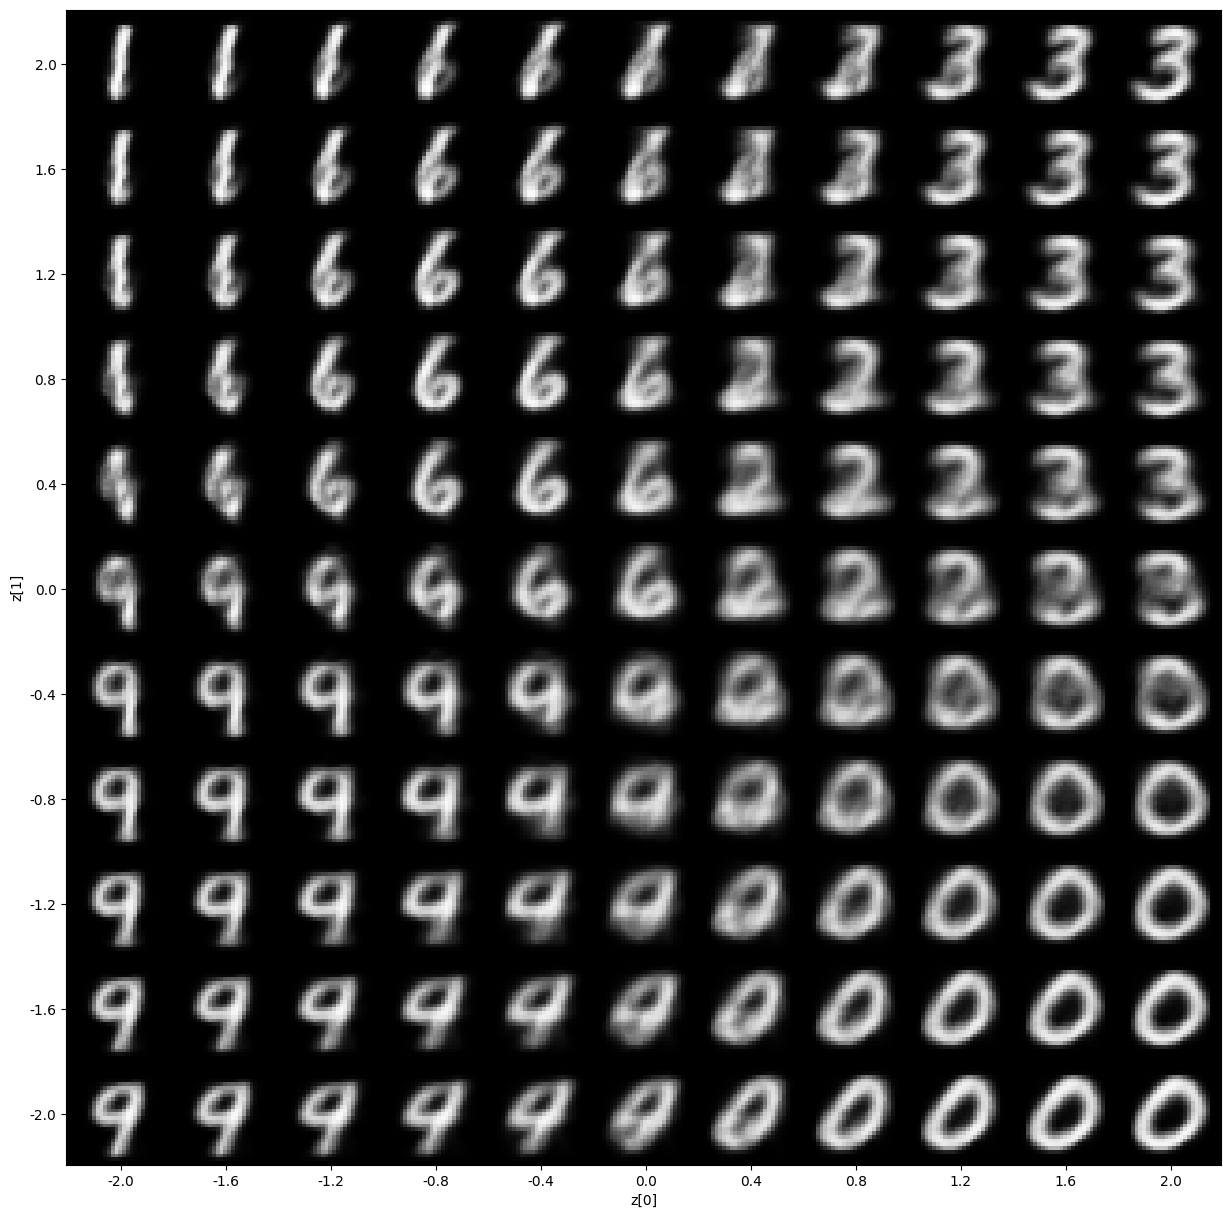

====================== END OF EXPT beta_0.004, lr_0.1 ======================================
====================== START OF EXPT beta_0.005, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 784)            │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 196)            │        153,860 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_4 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.005, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.005
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_40']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_46']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 44.1372
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 30.1277
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 28.9295
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 28.5221
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 28.1626
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 27.9454
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 27.8067
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 27.6941
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 27.6412
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 27.5744
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 27.5469
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 27.5150
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 27.3644
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 27.3250
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_46']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

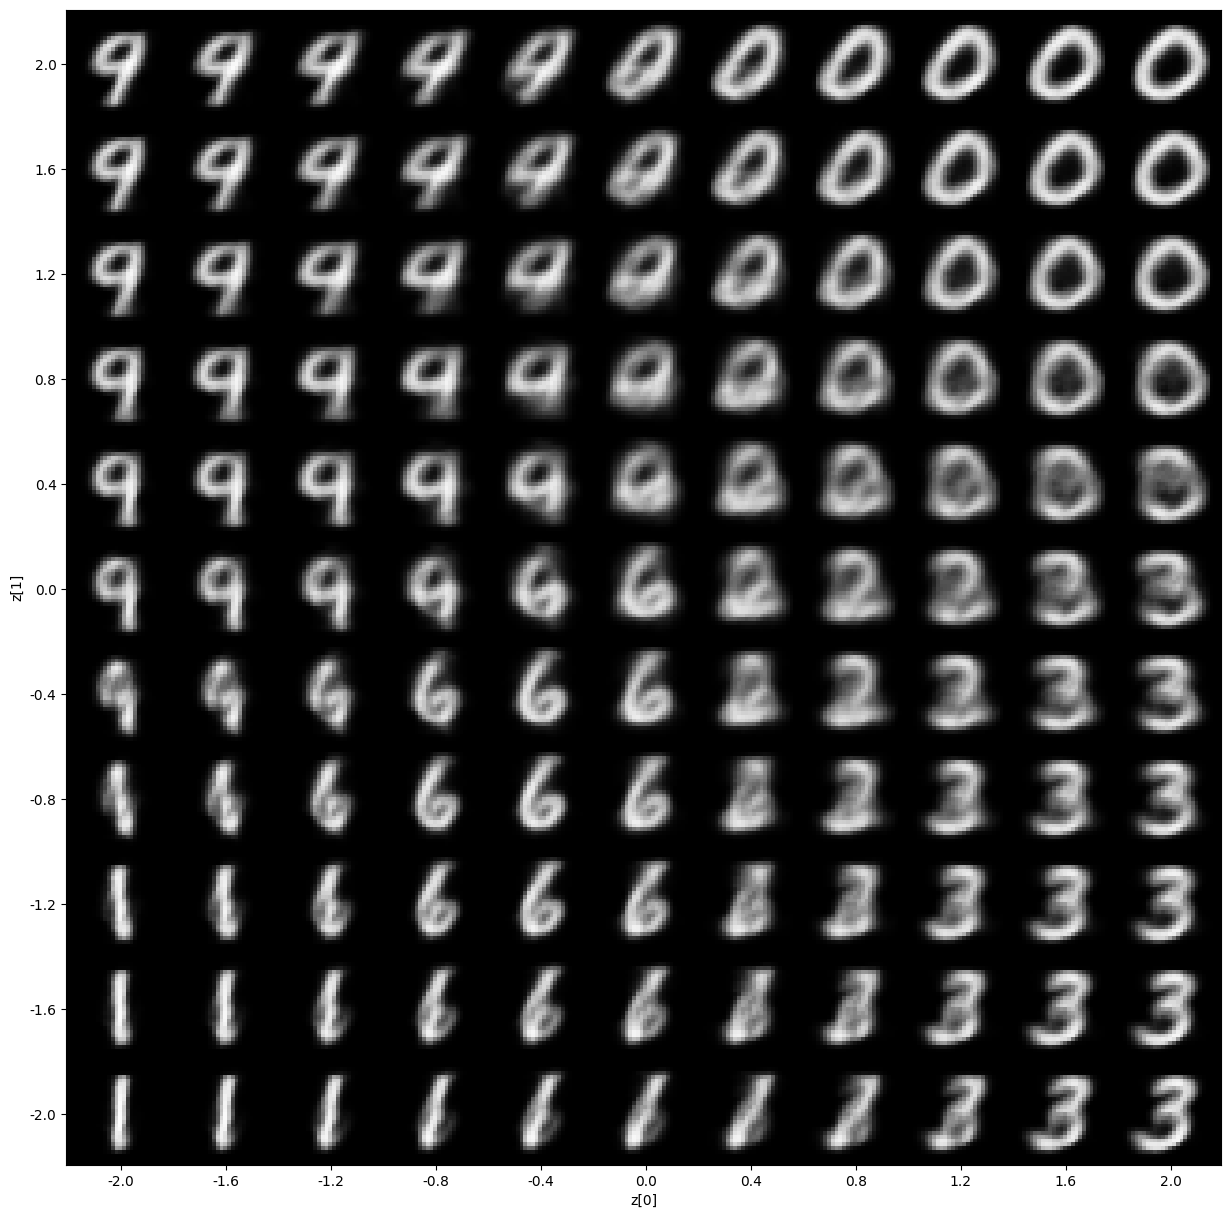

====================== END OF EXPT beta_0.005, lr_0.1 ======================================
====================== START OF EXPT beta_0.006, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 784)            │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 196)            │        153,860 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_5 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.006, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.006
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_50']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_56']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 43.0664
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 31.2509
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 29.1969
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 28.7827
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 28.4509
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 28.2044
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 28.1245
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 27.9302
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 27.8168
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 27.8561
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 27.7633
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 27.7287
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 27.6137
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 27.6427
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_56']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

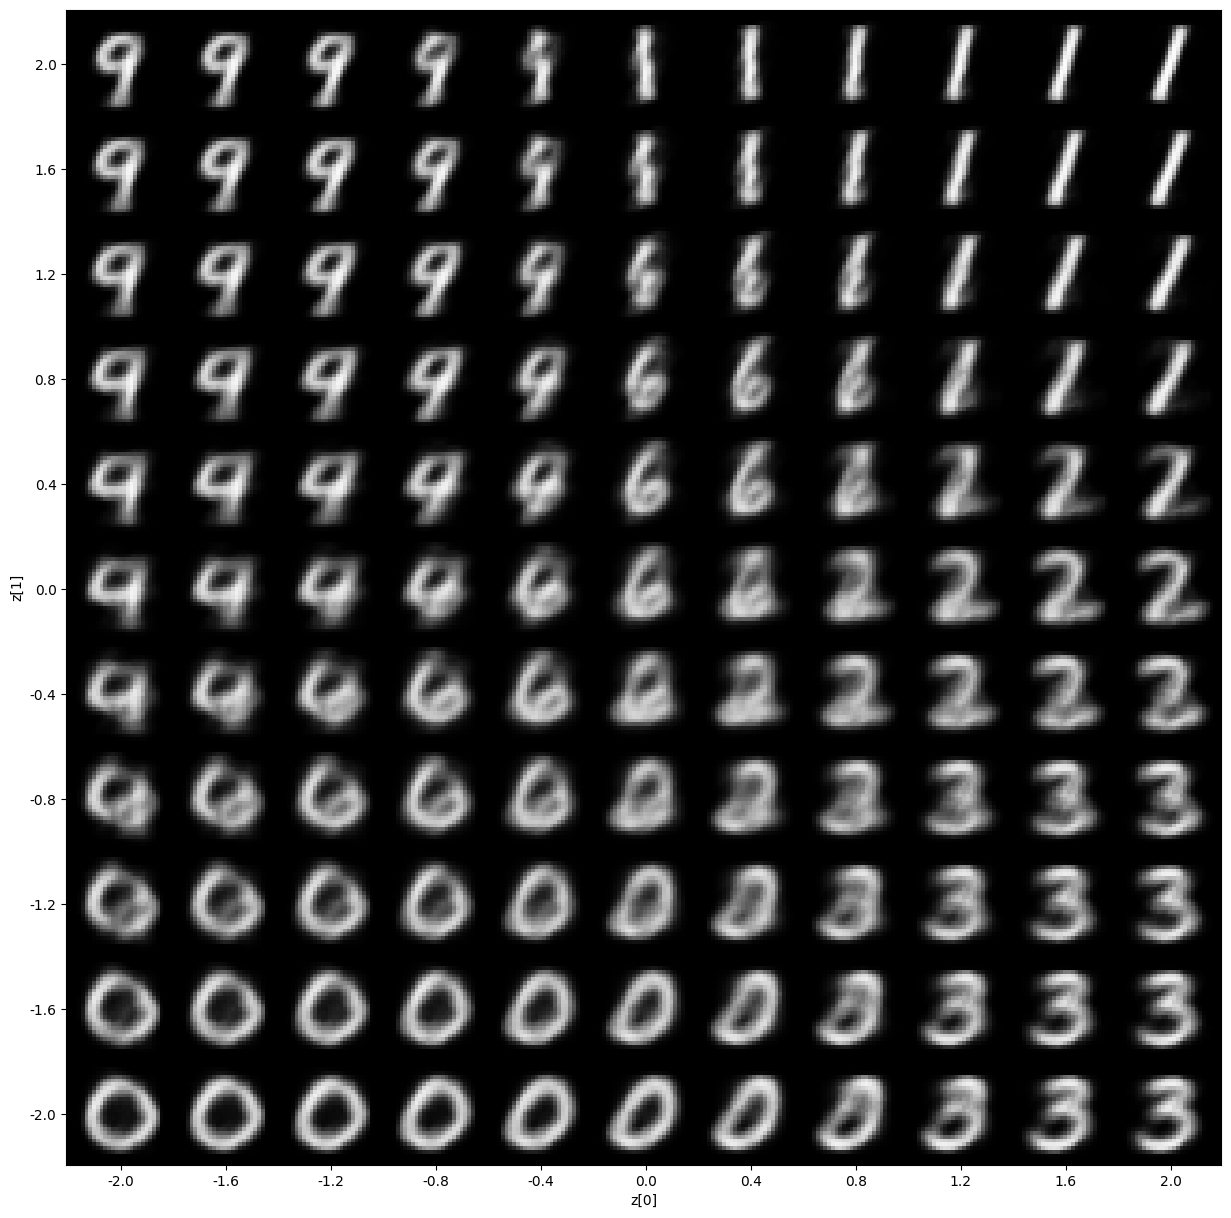

====================== END OF EXPT beta_0.006, lr_0.1 ======================================
====================== START OF EXPT beta_0.007, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 784)            │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 196)            │        153,860 │ flatten_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_6 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.007, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.007
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_60']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 43.2662
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 30.0635
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 29.3087
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 28.8853
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 28.6264
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 28.4771
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 28.2817
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 28.1853
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 28.0222
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 27.9862
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 28.1128
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 28.0072
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 27.8999
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 27.8708
Epoch 15/20
388/388 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

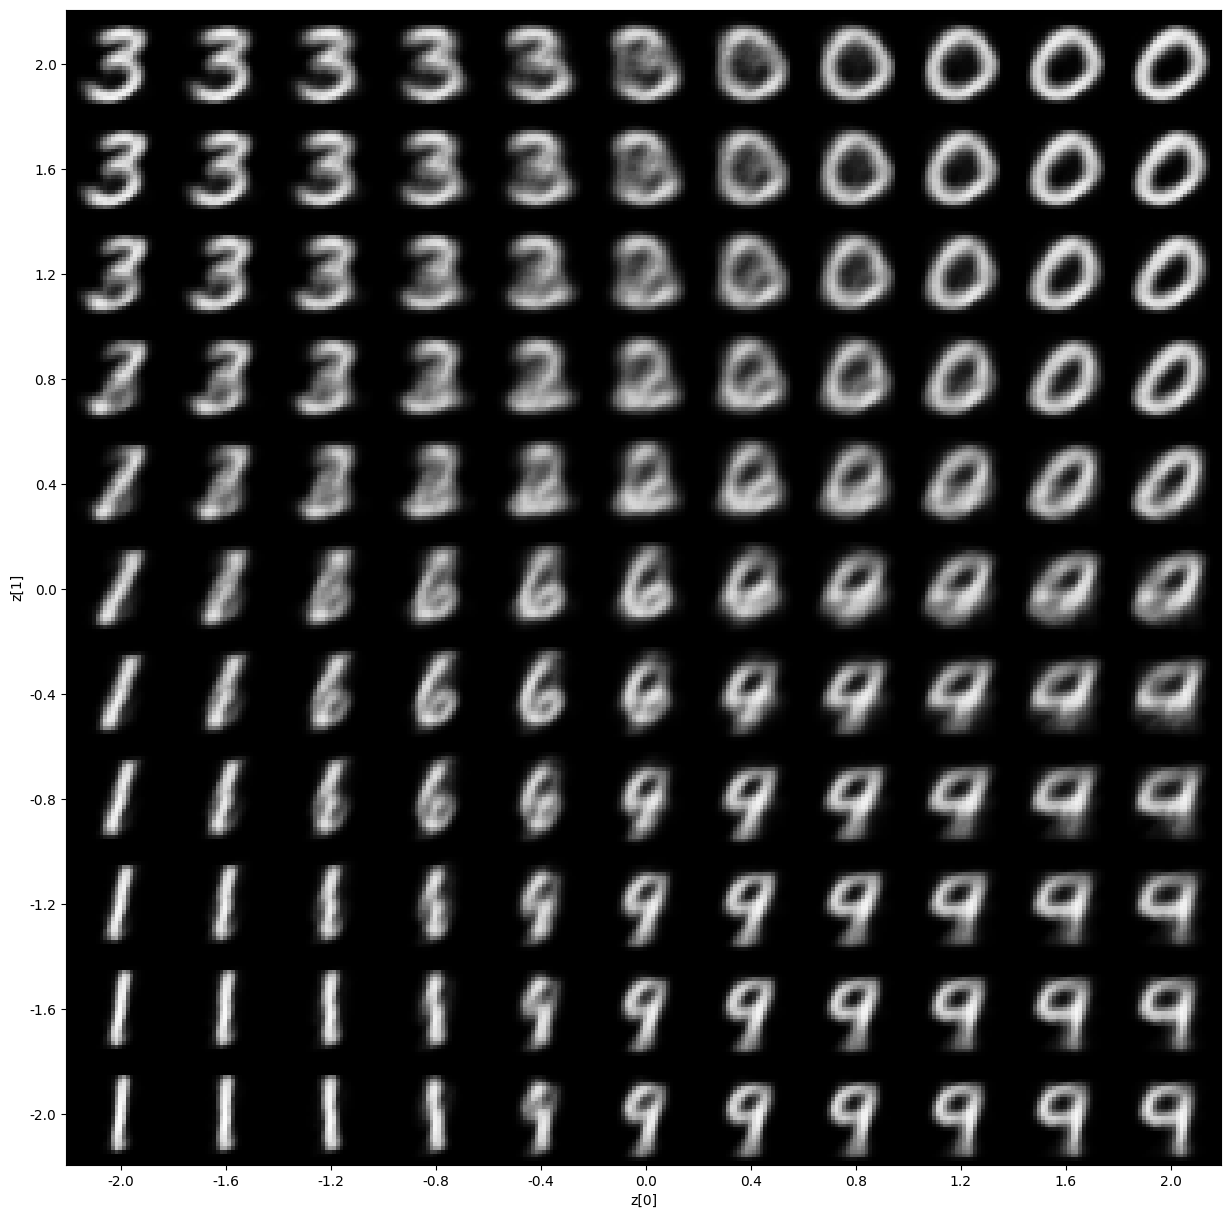

====================== END OF EXPT beta_0.007, lr_0.1 ======================================
====================== START OF EXPT beta_0.008, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 784)            │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 196)            │        153,860 │ flatten_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_7 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.008, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.008
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_76']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 55.7270
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 31.9761
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 30.3363
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 29.7171
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 29.3673
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 29.1163
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 28.9565
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 28.8590
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 28.7391
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 28.6764
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 28.5666
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 28.5238
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 28.5238
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 28.4103
Epoch 15/20
388/388 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_76']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

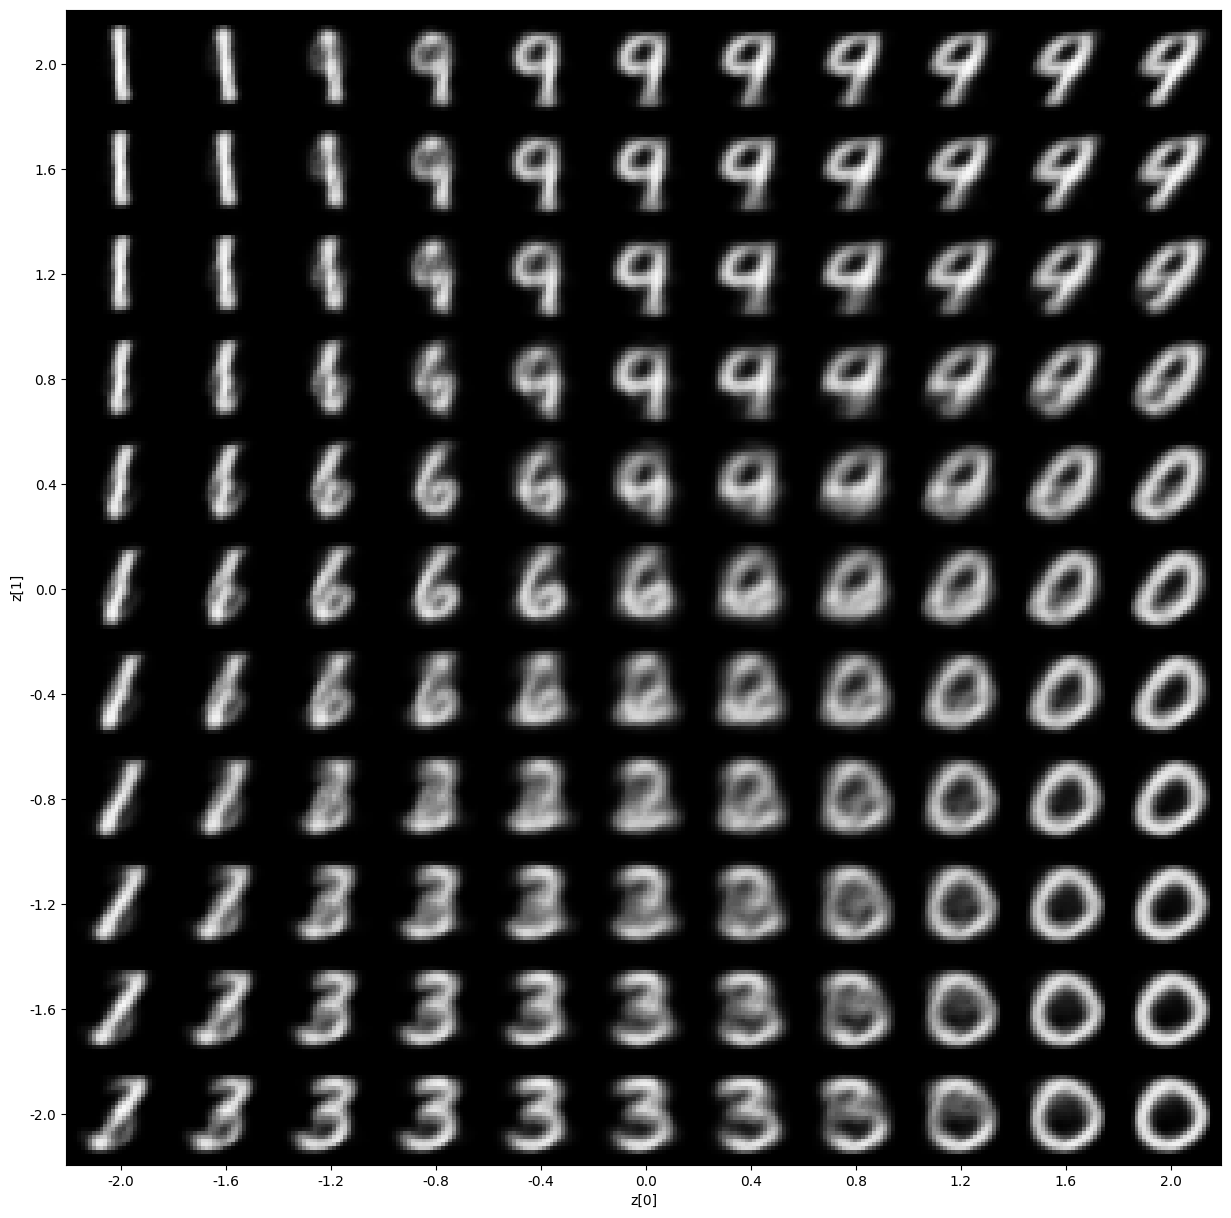

====================== END OF EXPT beta_0.008, lr_0.1 ======================================
====================== START OF EXPT beta_0.009, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 784)            │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 196)            │        153,860 │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_8 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.009, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.009
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_80']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_86']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 43.5727
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 30.9246
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 29.9811
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 29.5632
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 29.2964
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 29.1199
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 29.0231
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 28.8423
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 28.6956
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 28.8052
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 28.6309
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 28.6255
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 28.5937
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 28.5243
Epoch 15/20
388/388 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_86']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

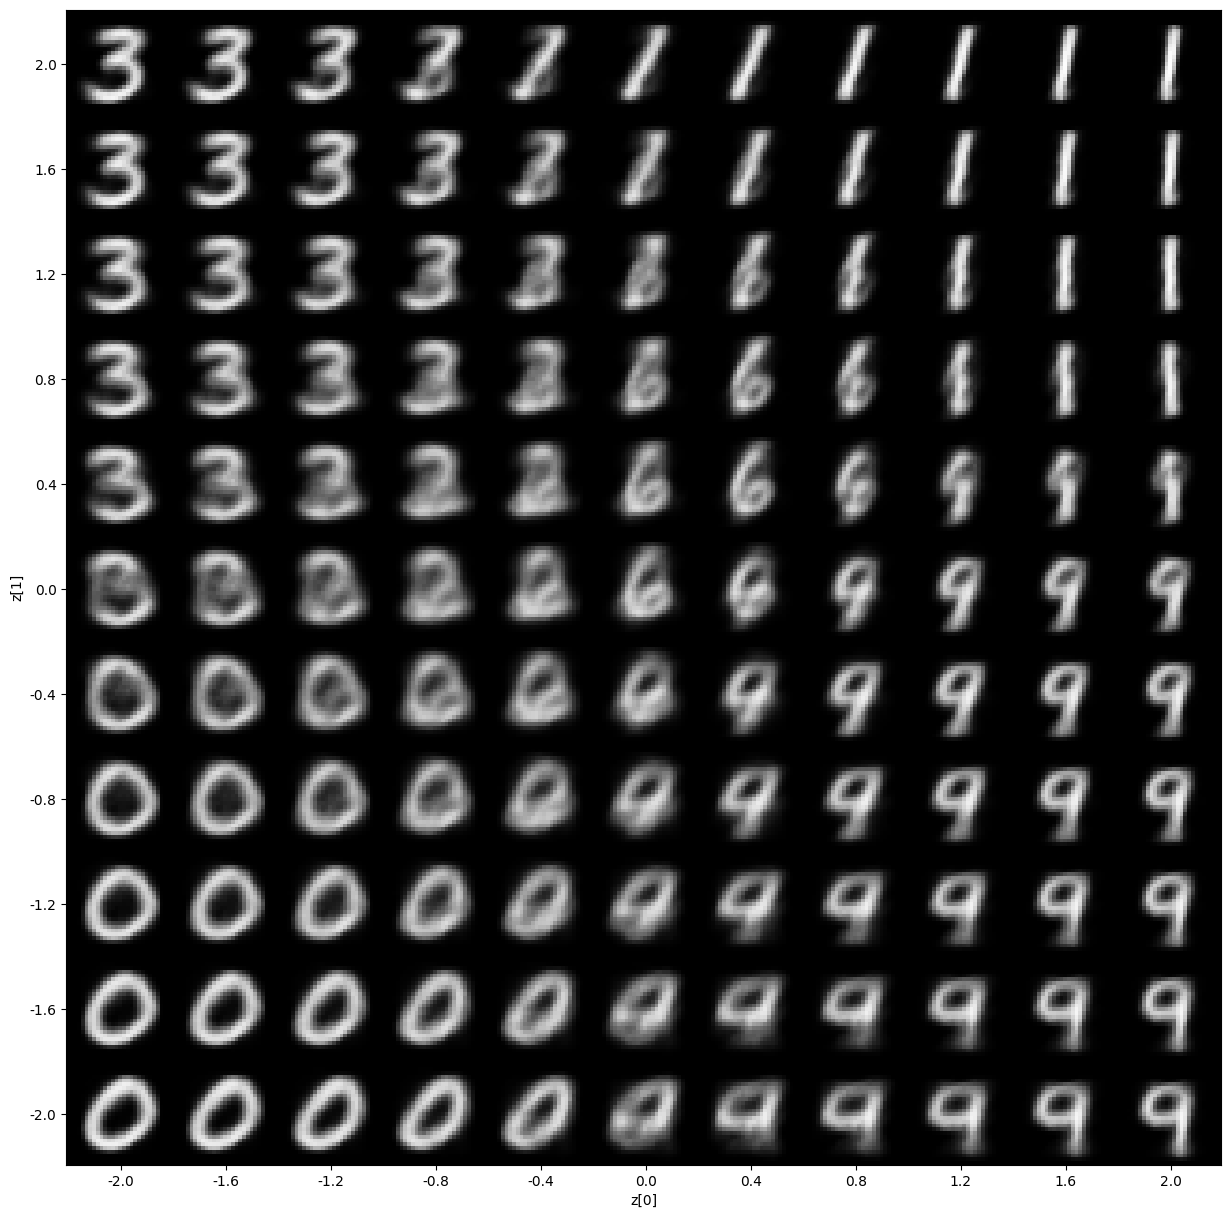

====================== END OF EXPT beta_0.009, lr_0.1 ======================================
====================== START OF EXPT beta_0.01, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 784)            │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 196)            │        153,860 │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_9 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.01, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.01
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_90']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_96']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 51.9937
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 32.2248
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 30.4485
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 29.8941
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 29.7841
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 29.5914
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 29.4567
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 29.3521
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 29.3038
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 29.2206
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 29.3267
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 29.1386
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 29.1424
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 29.0947
Epoch 15/20
388/388 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_96']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

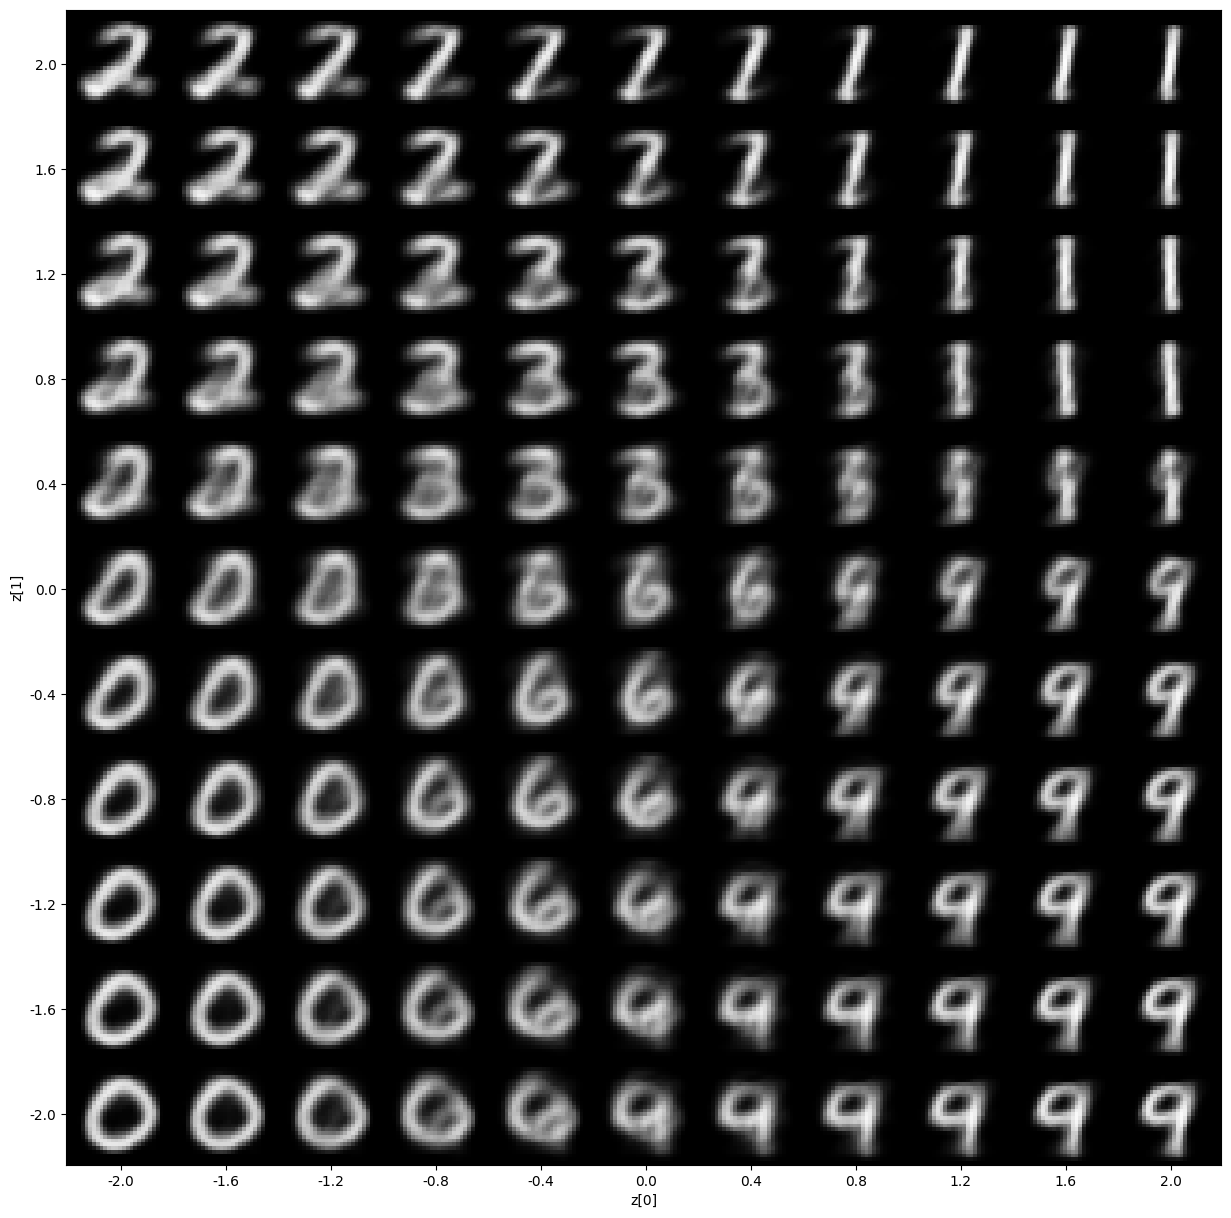

====================== END OF EXPT beta_0.01, lr_0.1 ======================================
====================== START OF EXPT beta_0.002, lr_0.01 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 784)            │              0 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 196)            │        153,860 │ flatten_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_10 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_10 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.01
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.01
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_100']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_106']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 56.7035
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 33.2487
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 31.6053
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 30.8448
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 30.0953
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 29.6565
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 29.3969
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 29.2003
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 29.0477
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 28.8951
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 28.7551
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 28.6174
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 28.4896
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 28.3789
Epoch 15/20
388/388 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_106']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

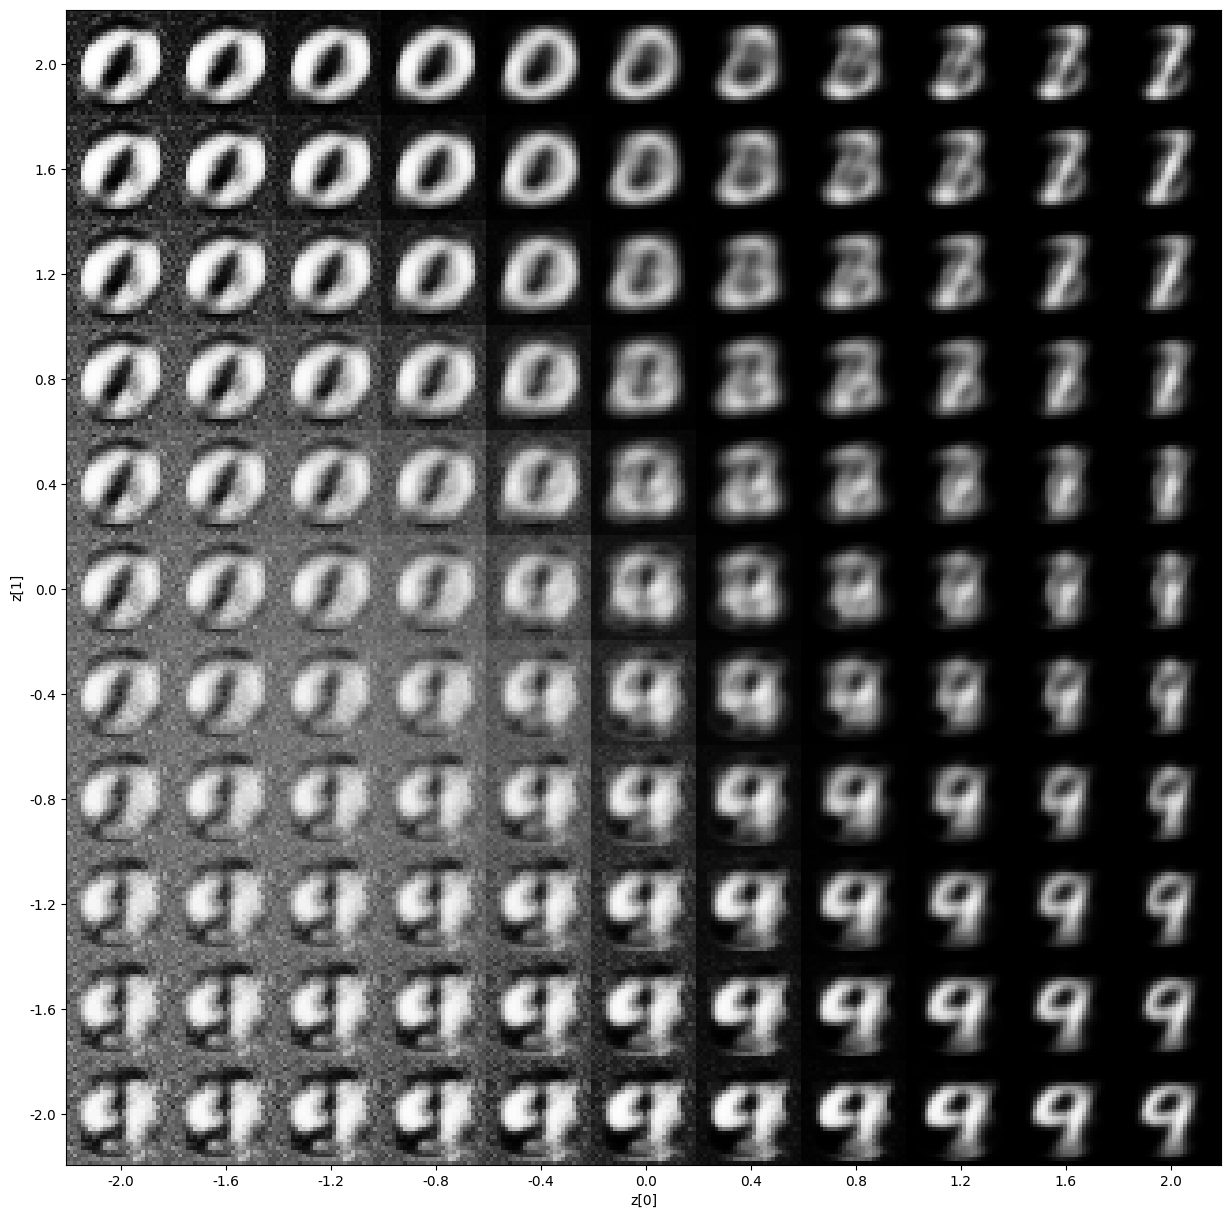

====================== END OF EXPT beta_0.002, lr_0.01 ======================================
====================== START OF EXPT beta_0.002, lr_0.02 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 784)            │              0 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 196)            │        153,860 │ flatten_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_11 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_11 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.02
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.02
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_110']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_116']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 48.2170
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 31.4319
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 30.5920
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 29.9356
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 29.5484
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 29.2546
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 28.9792
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 28.7039
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 28.4960
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 28.3104
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 28.1719
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 28.0286
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 27.8694
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 27.7529
Epoch 15/20
388/388 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_116']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

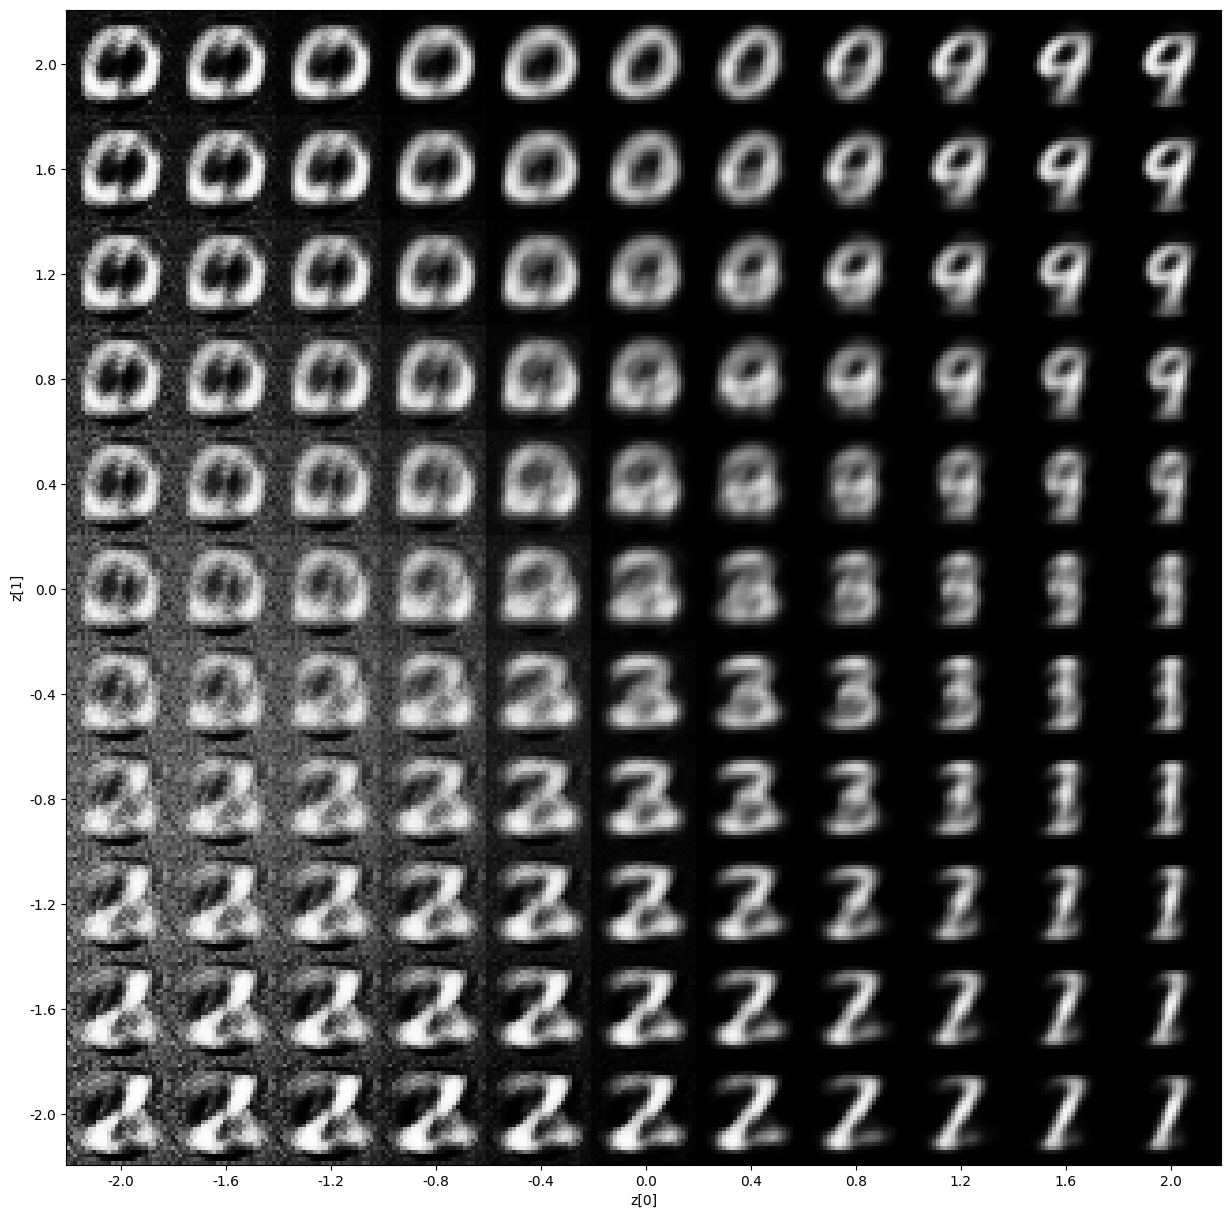

====================== END OF EXPT beta_0.002, lr_0.02 ======================================
====================== START OF EXPT beta_0.002, lr_0.03 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 784)            │              0 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 196)            │        153,860 │ flatten_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_12 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_12 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.03
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.03
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_120']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_126']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 44.8572
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 30.8512
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 29.8416
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 29.3506
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 28.9321
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 28.5813
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 28.2892
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 28.0478
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 27.8451
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 27.6680
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 27.4778
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 27.3154
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 27.1509
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 26.9819
Epoch 15/20
388/388 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_126']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

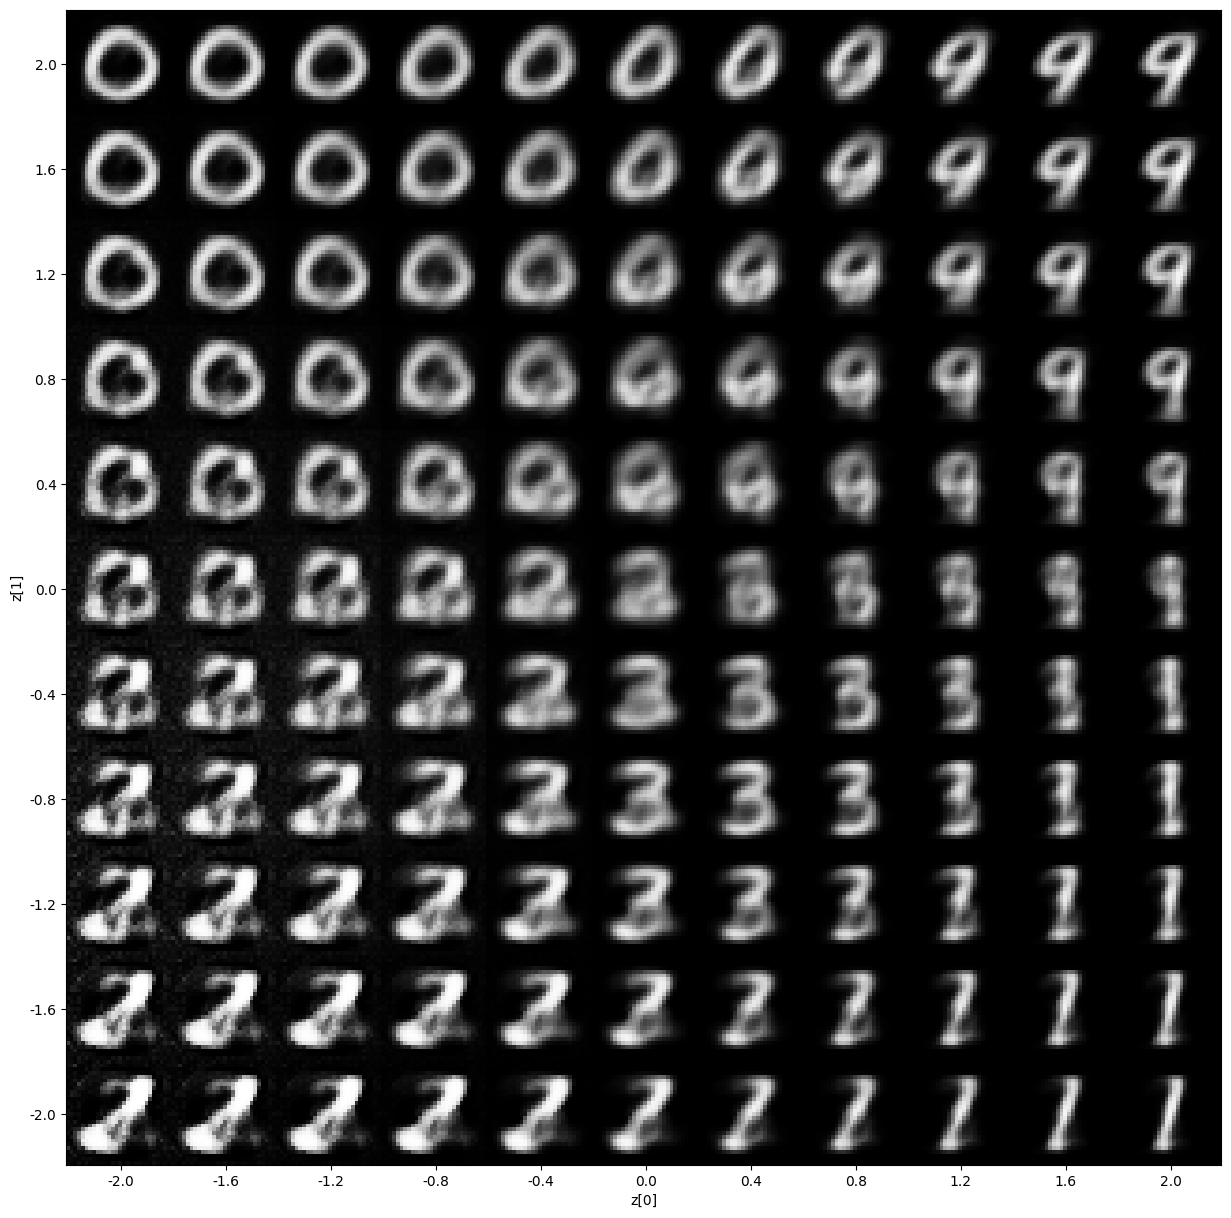

====================== END OF EXPT beta_0.002, lr_0.03 ======================================
====================== START OF EXPT beta_0.002, lr_0.04 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_13 (Flatten)      │ (None, 784)            │              0 │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 196)            │        153,860 │ flatten_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_13 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_13 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.04
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.04
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_130']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_136']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 43.3047
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 30.4139
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 29.5178
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 28.9527
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 28.4838
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 28.1202
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 27.8252
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 27.5538
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 27.3129
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 27.1021
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 26.8554
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 26.6692
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 26.4854
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 26.2643
Epoch 15/20
388/388 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_136']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

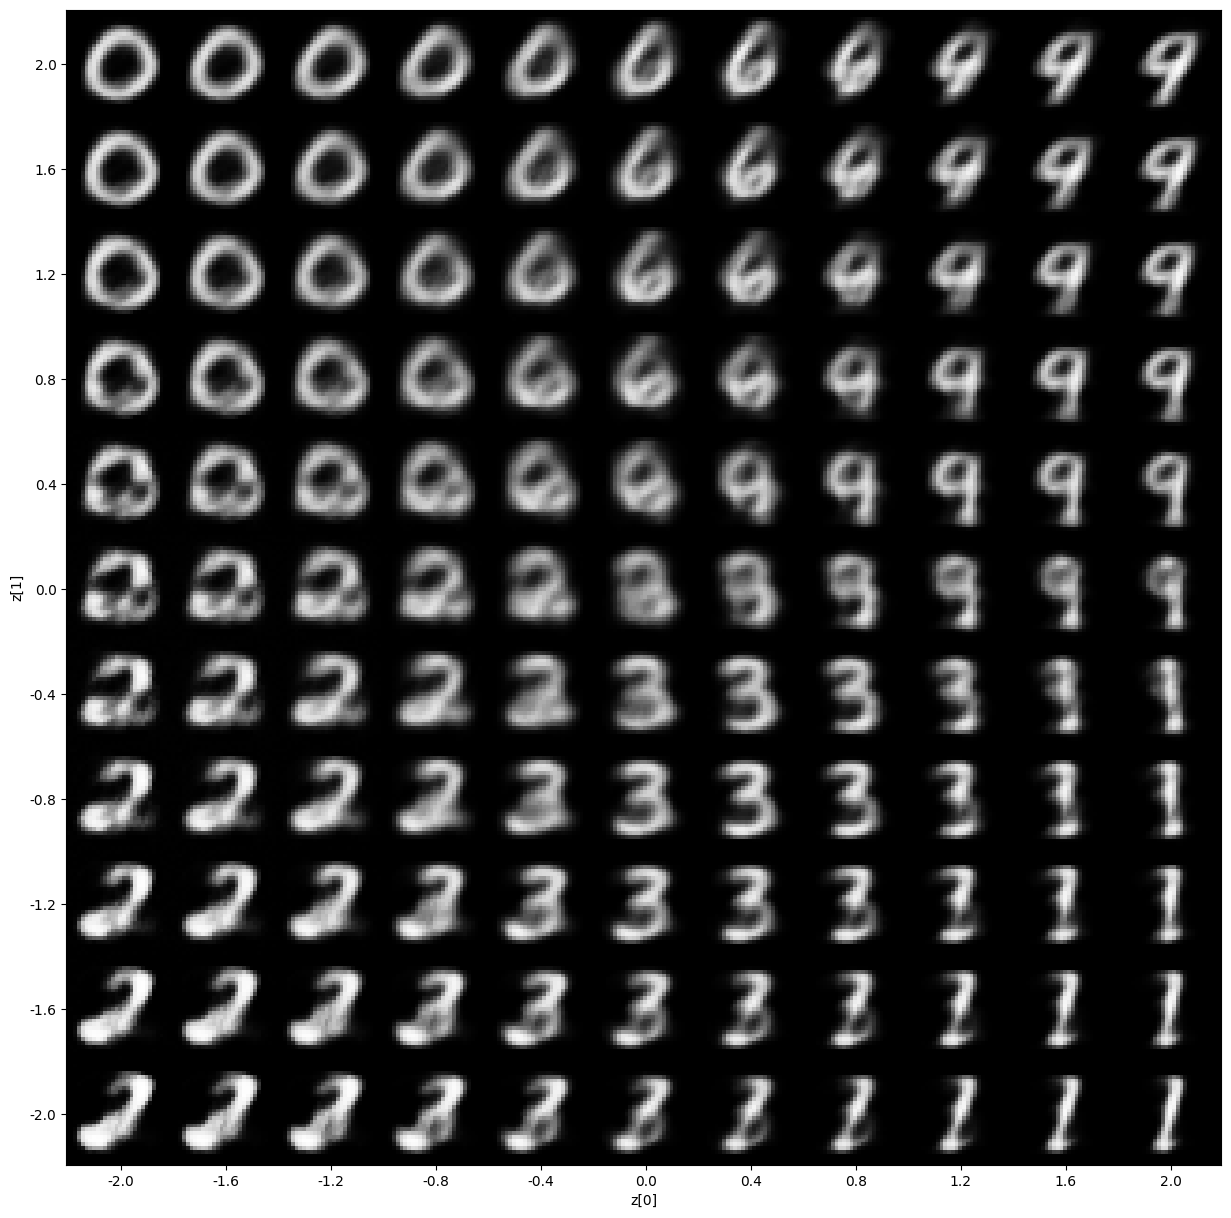

====================== END OF EXPT beta_0.002, lr_0.04 ======================================
====================== START OF EXPT beta_0.002, lr_0.05 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 784)            │              0 │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 196)            │        153,860 │ flatten_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_14 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_14 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.05
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.05
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_140']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_146']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 43.0965
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 29.9328
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 29.1121
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 28.4718
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 28.0070
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 27.6482
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 27.2860
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 26.9905
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 26.7075
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 26.4795
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 26.3103
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 26.1005
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 25.9241
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 25.7527
Epoch 15/20
388/388 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_146']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

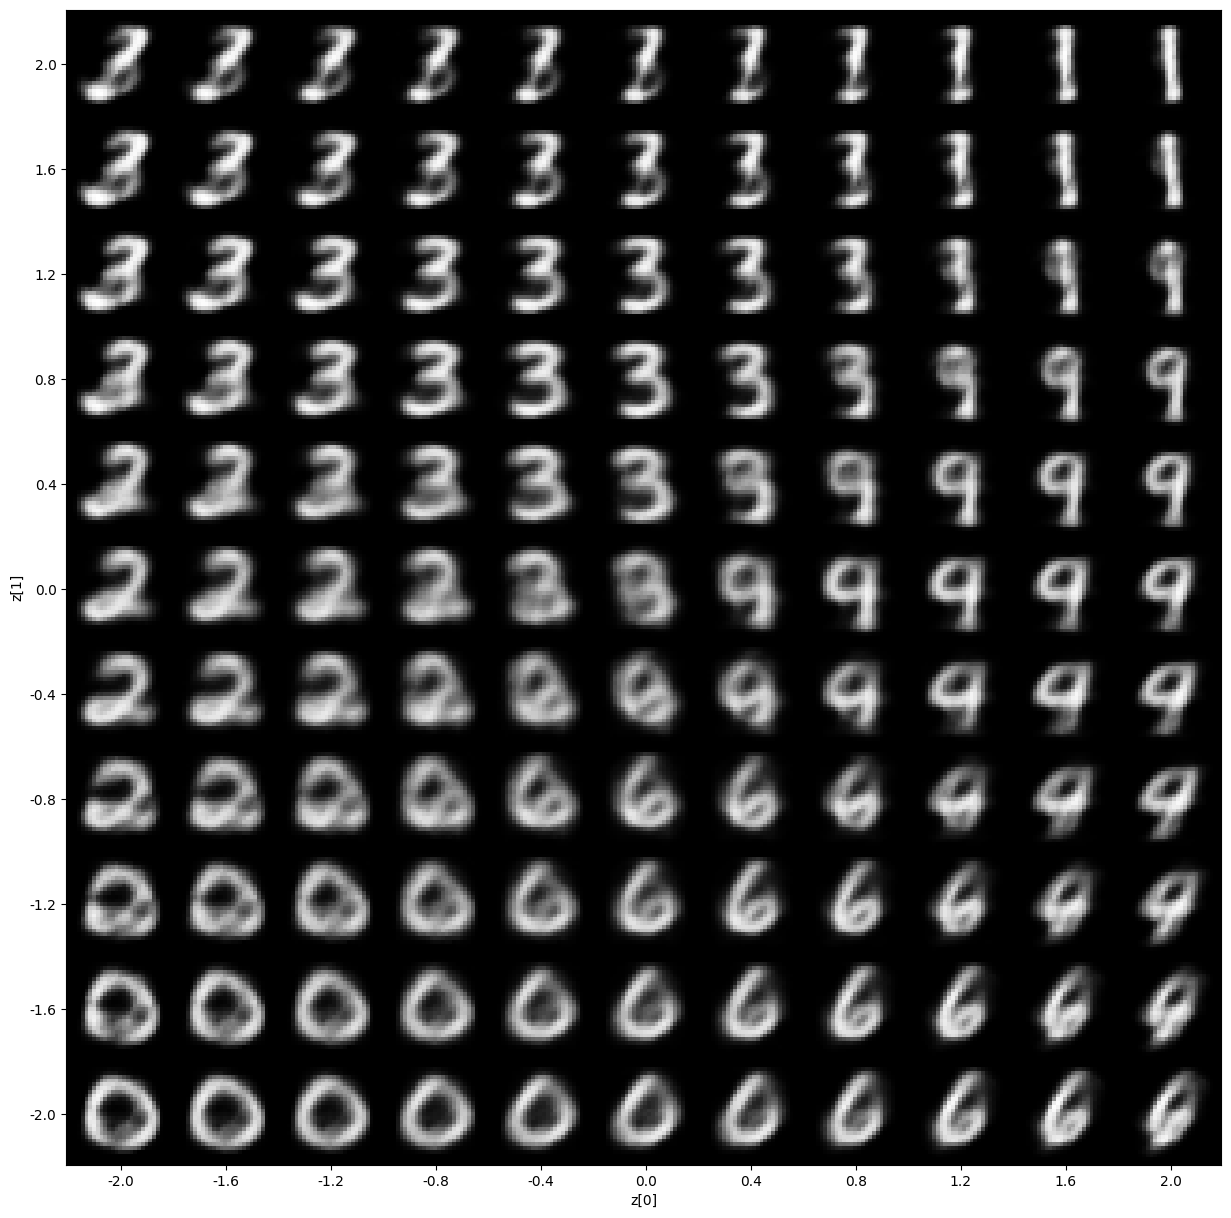

====================== END OF EXPT beta_0.002, lr_0.05 ======================================
====================== START OF EXPT beta_0.002, lr_0.1 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_15 (Flatten)      │ (None, 784)            │              0 │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 196)            │        153,860 │ flatten_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_15 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_15 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.1
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.1
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_150']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_156']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 43.5031
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 30.2209
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 28.5171
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 27.5348
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 27.0536
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 26.7818
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 26.5911
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 26.3778
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 26.2817
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 26.1696
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 25.9957
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 25.8866
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 25.8105
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 25.7604
Epoch 15/20
388/388 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_156']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

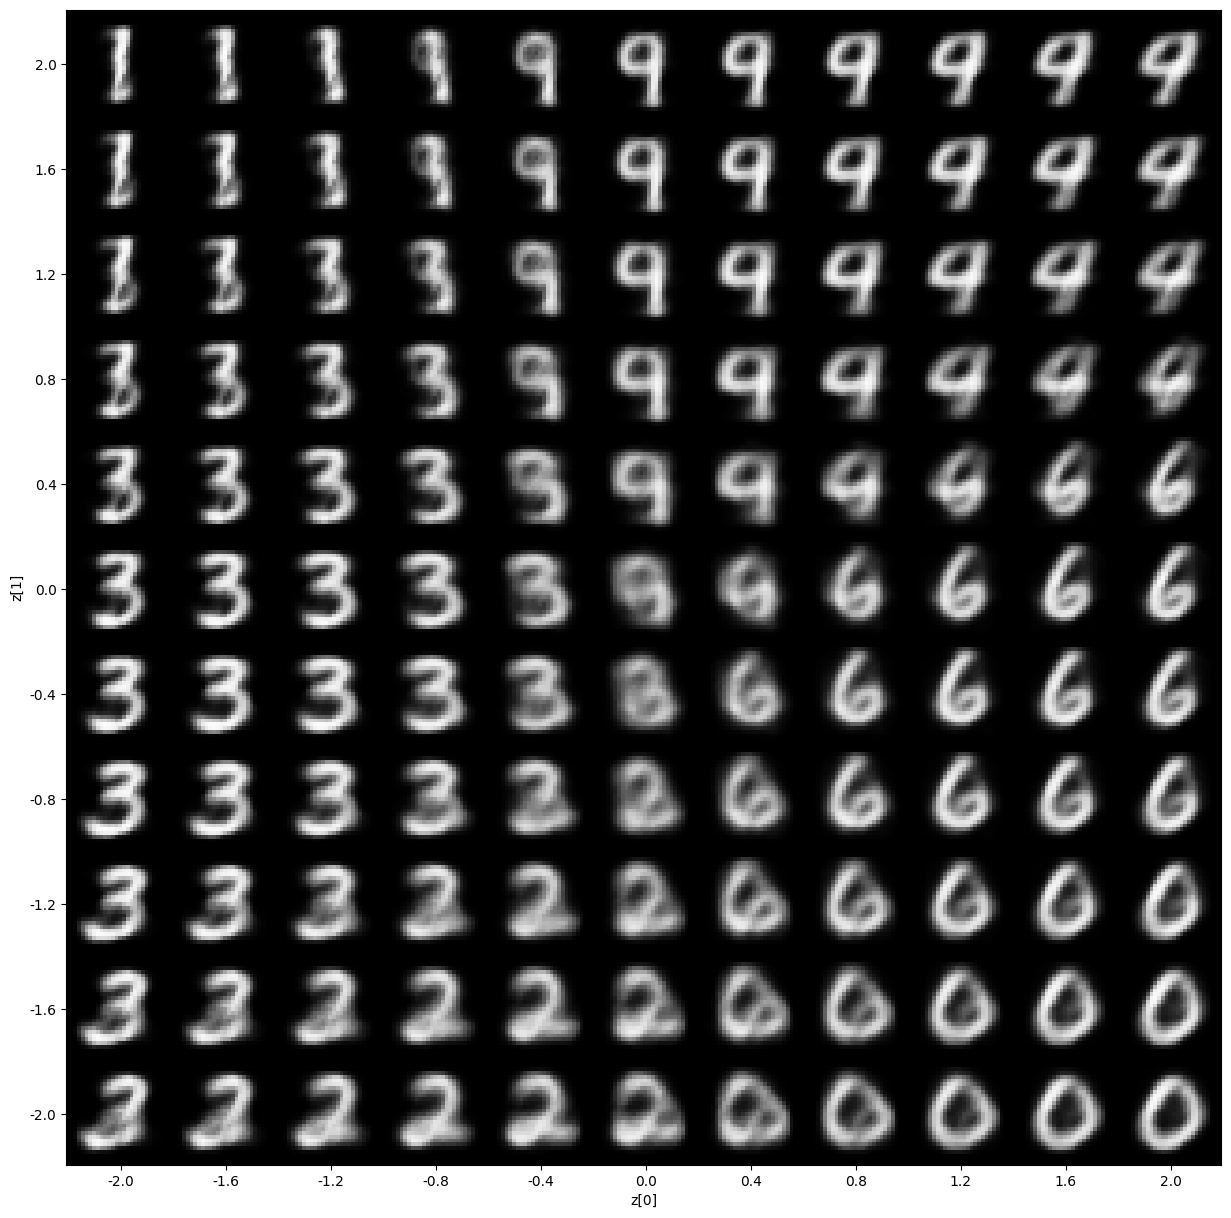

====================== END OF EXPT beta_0.002, lr_0.1 ======================================
====================== START OF EXPT beta_0.002, lr_0.001 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_16 (Flatten)      │ (None, 784)            │              0 │ input_layer_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 196)            │        153,860 │ flatten_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_48[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_48[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_16 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_16 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.001
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.001
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_160']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_166']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 88.0268
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 63.8675
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 39.0775
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 36.8162
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 35.7579
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 35.0863
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 34.6425
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 34.3192
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 34.0744
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 33.8699
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 33.6864
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 33.4858
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 33.2541
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 32.9724
Epoch 15/20
388/388 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_166']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

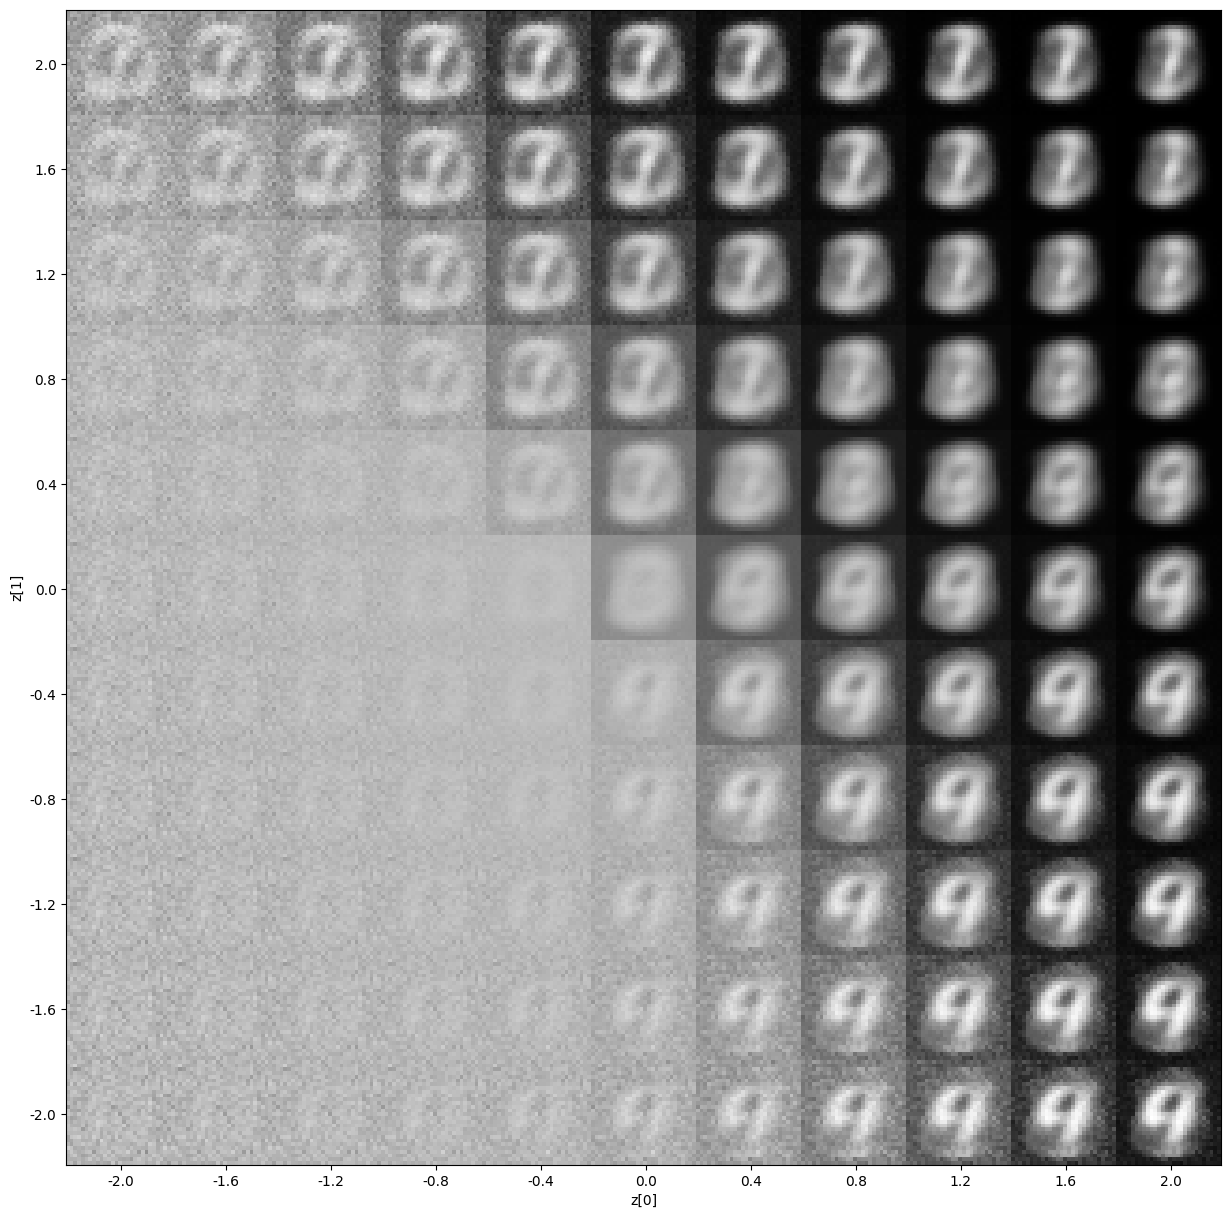

====================== END OF EXPT beta_0.002, lr_0.001 ======================================
====================== START OF EXPT beta_0.002, lr_0.002 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 784)            │              0 │ input_layer_34[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 196)            │        153,860 │ flatten_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_17 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_17 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.002
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.002
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_170']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_176']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 83.4151
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 38.5182
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 35.5878
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 34.5635
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 34.0302
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 33.6426
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 33.2167
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 32.6685
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 32.2298
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 31.9496
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 31.7629
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 31.6146
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 31.4967
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 31.3926
Epoch 15/20
388/388 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_176']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

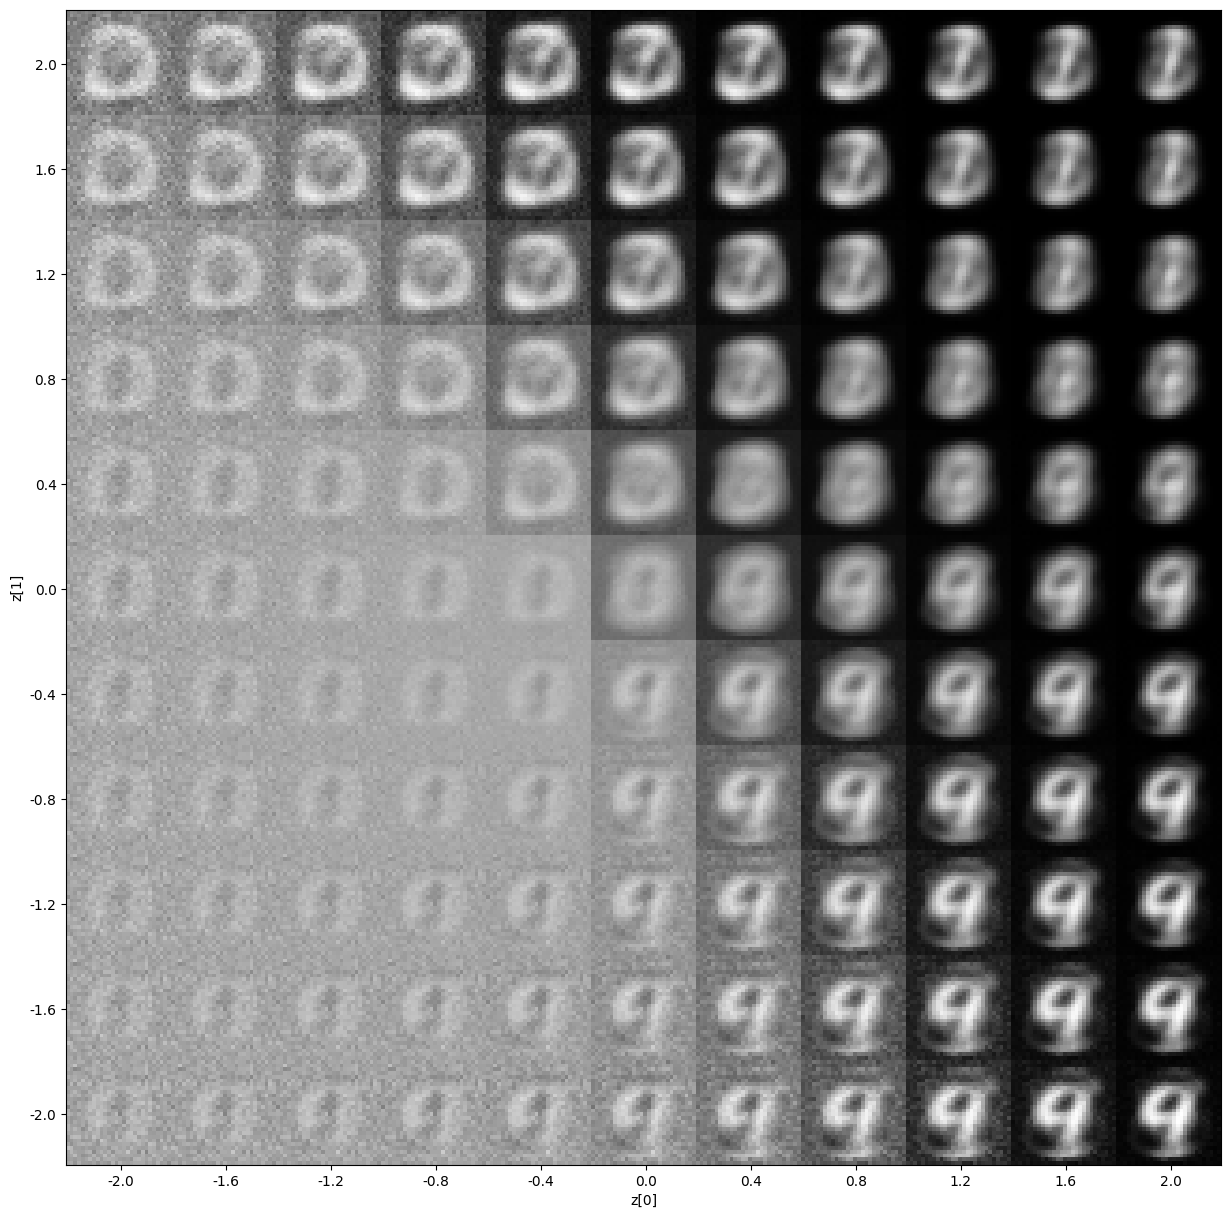

====================== END OF EXPT beta_0.002, lr_0.002 ======================================
====================== START OF EXPT beta_0.002, lr_0.003 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_18 (Flatten)      │ (None, 784)            │              0 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_54 (Dense)          │ (None, 196)            │        153,860 │ flatten_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_54[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_54[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_18 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_18 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.003
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.003
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_180']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_186']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 76.9532
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 36.3356
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 34.4880
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 33.7819
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 33.1566
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 32.3737
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 31.8908
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 31.5945
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 31.3641
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 31.1431
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 30.9193
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 30.6708
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 30.4248
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 30.2033
Epoch 15/20
388/388 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_186']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

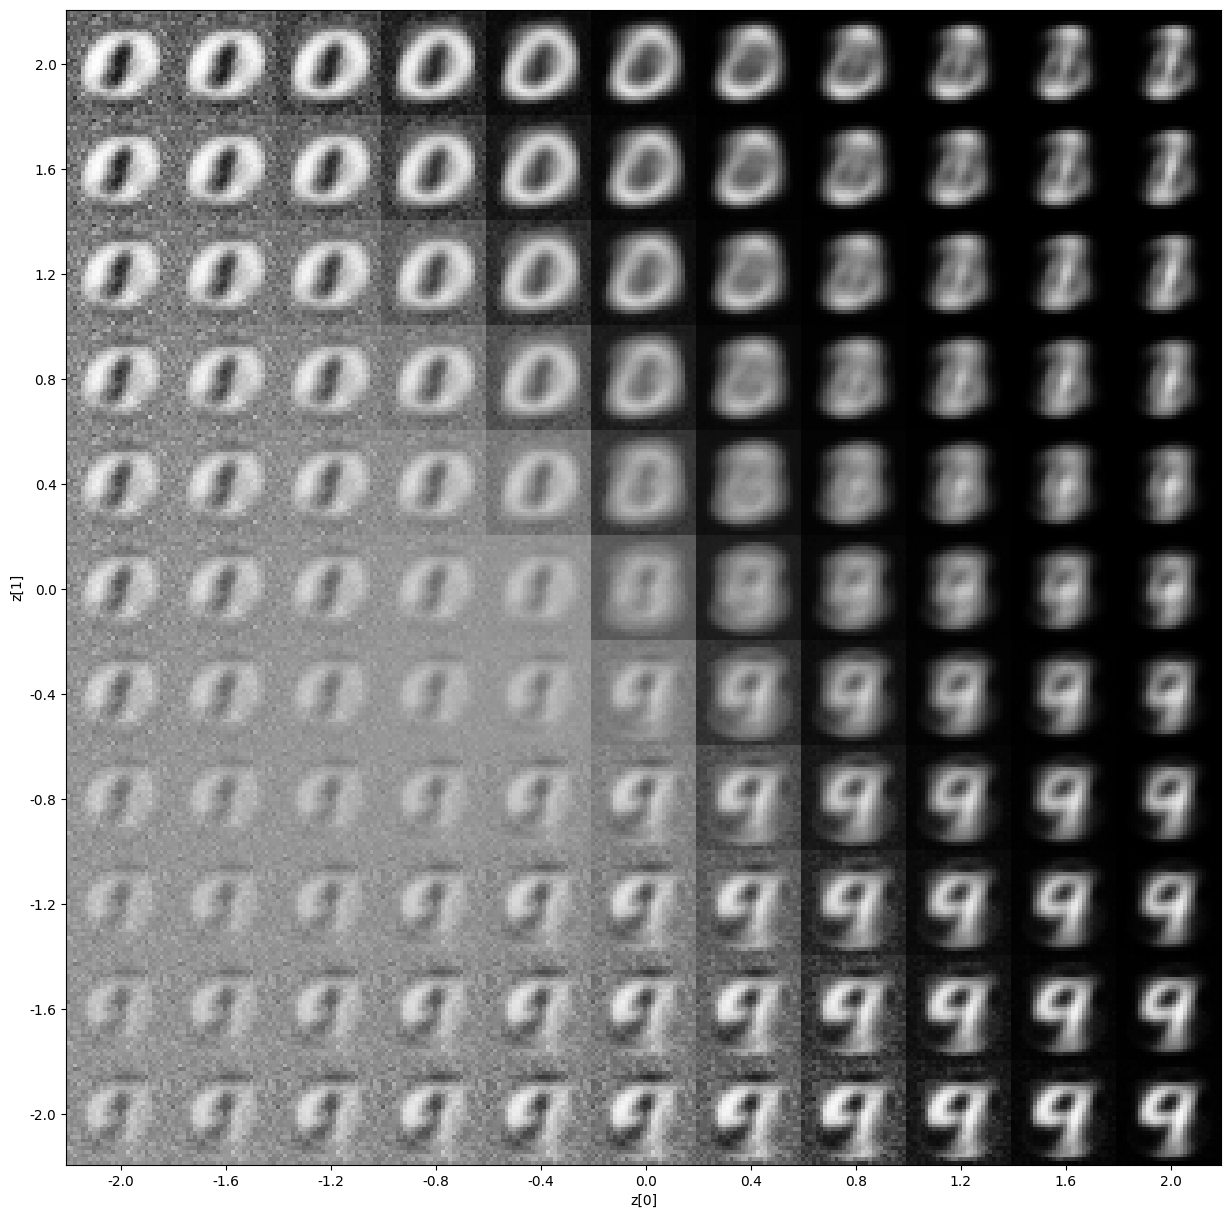

====================== END OF EXPT beta_0.002, lr_0.003 ======================================
====================== START OF EXPT beta_0.002, lr_0.004 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_19 (Flatten)      │ (None, 784)            │              0 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_57 (Dense)          │ (None, 196)            │        153,860 │ flatten_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_57[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_57[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_19 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_19 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.004
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.004
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_190']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_196']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 71.8484
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 35.3207
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 33.9140
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 33.0286
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 32.0890
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 31.5961
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 31.2486
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 30.9189
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 30.5850
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 30.2759
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 30.0393
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 29.8517
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 29.7041
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 29.5837
Epoch 15/20
388/388 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_196']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

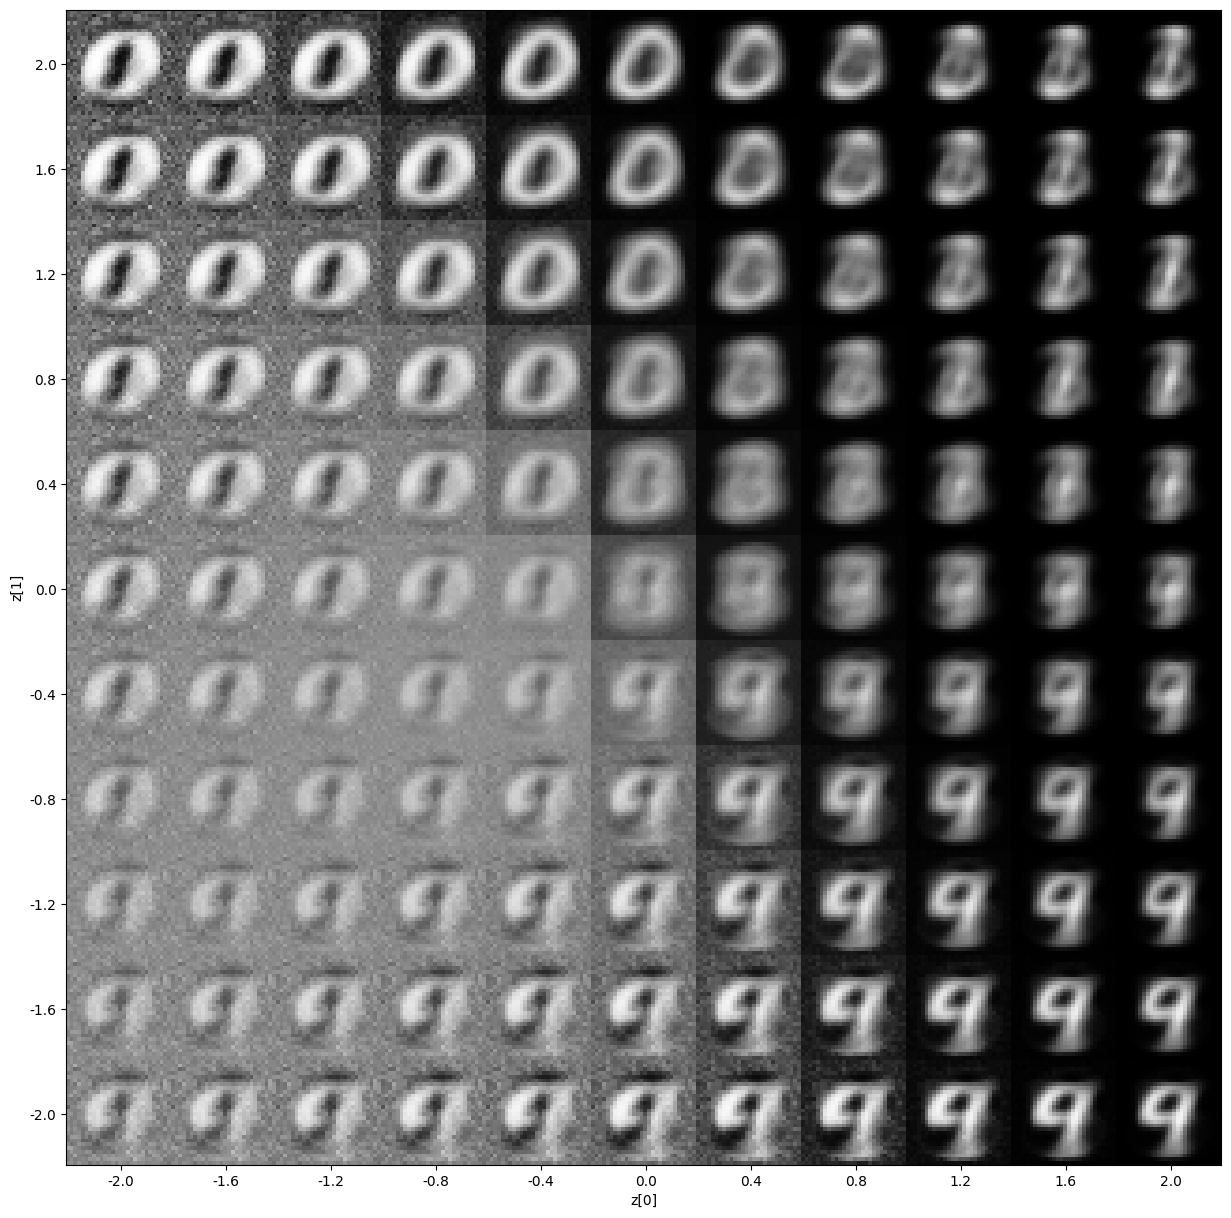

====================== END OF EXPT beta_0.002, lr_0.004 ======================================
====================== START OF EXPT beta_0.002, lr_0.005 ====================================


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_20 (Flatten)      │ (None, 784)            │              0 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 196)            │        153,860 │ flatten_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            394 │ dense_60[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            394 │ dense_60[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_20 (Sampling)    │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 154,648 (604.09 KB)

 Trainable params: 154,648 (604.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 196)                 │             588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 784)                 │         154,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_20 (Reshape)                 │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,036 (605.61 KB)

 Trainable params: 155,036 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

    Experiment: beta_0.002, lr_0.005
Encoder Dims: [196]
Latent Dim: 2
Decoder Dims: [196]
Beta: 0.002
 Learning Rate: 0.005
        Epochs: 20
    Batch Size: 128
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_200']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_206']
Received: inputs=Tensor(shape=(None, 2))
  warnings.warn(msg)


388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 67.8997
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 34.7201
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 33.4722
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 32.2681
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 31.6193
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 31.2074
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 30.8007
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 30.3886
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 30.0660
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 29.8225
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 29.6502
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 29.5114
Epoch 13/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 29.3947
Epoch 14/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 29.2959
Epoch 15/20
388/388 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_206']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


Generating 22 of 121
Generating 33 of 121
Generating 44 of 121
Generating 55 of 121
Generating 66 of 121
Generating 77 of 121
Generating 88 of 121
Generating 99 of 121
Generating 110 of 121
Generating 121 of 121


<Figure size 640x480 with 0 Axes>

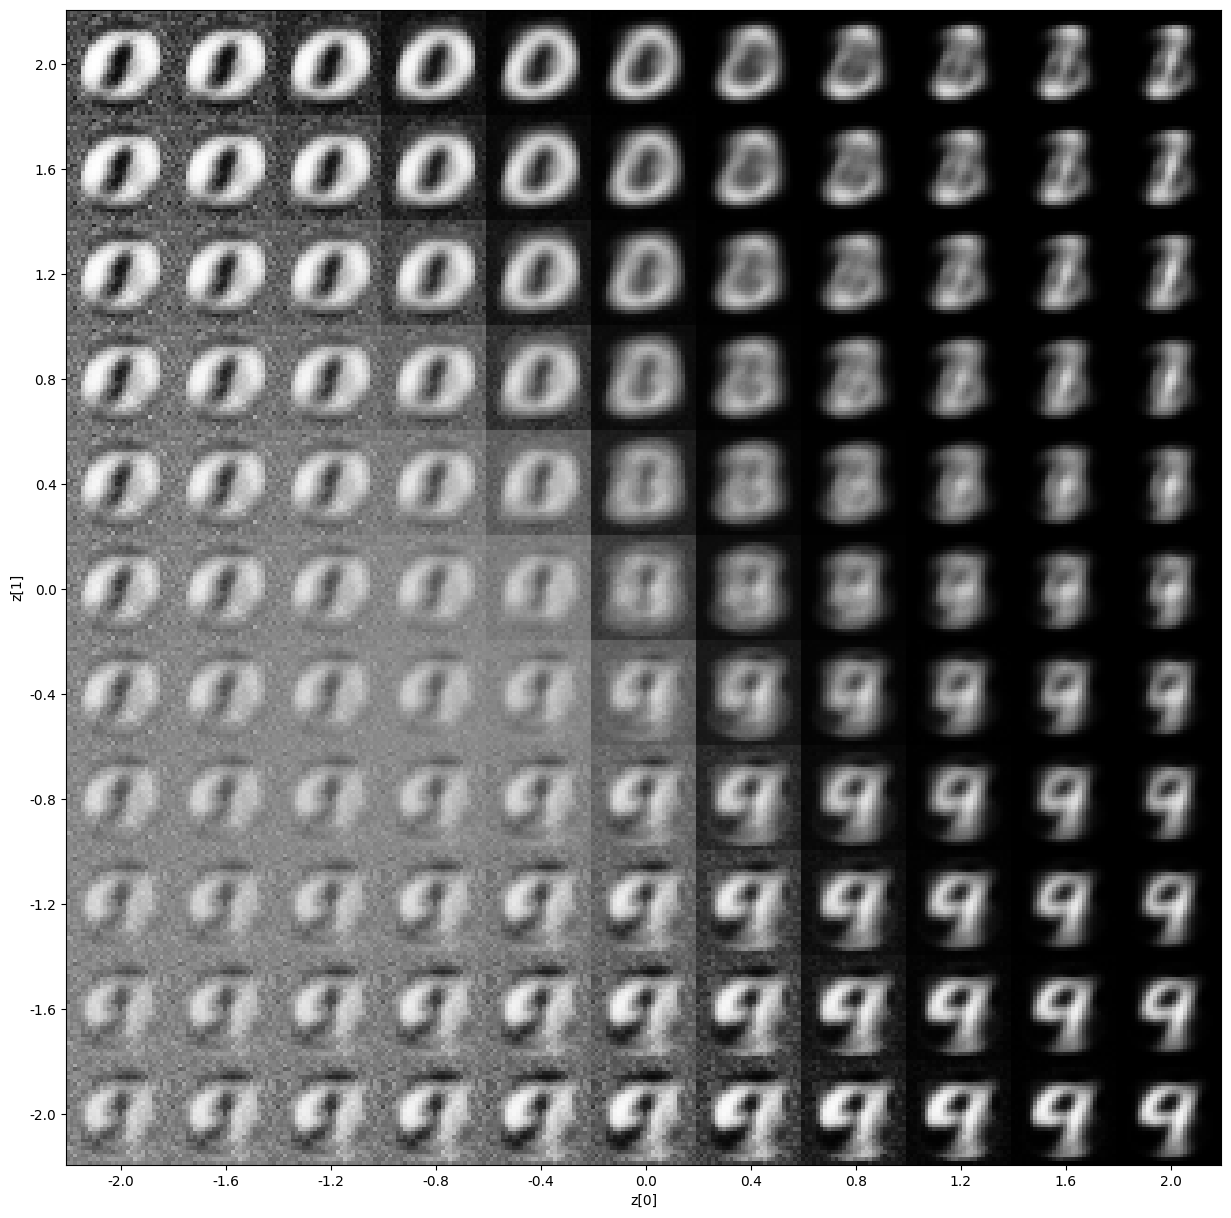

====================== END OF EXPT beta_0.002, lr_0.005 ======================================


<Figure size 640x480 with 0 Axes>

In [ ]:
experiments = [
  # (expt_name, [encoder_dims], latent_dim, [decoder_dims], beta, LR, epochs, batch, optimizer_type, layer_type)
#   ('a', [14*14], 2, [14*14], 0.002, 1e-1, 20, 128),
#   ('adam test', [196], 2, [196], 0.002, 1e-3, 10, 128, 'adam'),
#   ('cnn test', [32], 2, [32], 0.002, 1e-3, 10, 128, 'SGD', 'CNN')
    ('beta_0.001, lr_0.1', [14*14], 2, [14*14], 0.001, 0.1, 20, 128),
    ('beta_0.002, lr_0.1', [14*14], 2, [14*14], 0.002, 0.1, 20, 128),
    ('beta_0.003, lr_0.1', [14*14], 2, [14*14], 0.003, 0.1, 20, 128),
    ('beta_0.004, lr_0.1', [14*14], 2, [14*14], 0.004, 0.1, 20, 128),
    ('beta_0.005, lr_0.1', [14*14], 2, [14*14], 0.005, 0.1, 20, 128),
    ('beta_0.006, lr_0.1', [14*14], 2, [14*14], 0.006, 0.1, 20, 128),
    ('beta_0.007, lr_0.1', [14*14], 2, [14*14], 0.007, 0.1, 20, 128),
    ('beta_0.008, lr_0.1', [14*14], 2, [14*14], 0.008, 0.1, 20, 128),
    ('beta_0.009, lr_0.1', [14*14], 2, [14*14], 0.009, 0.1, 20, 128),
    ('beta_0.01, lr_0.1', [14*14], 2, [14*14], 0.01, 0.1, 20, 128),

    ('beta_0.002, lr_0.01', [14*14], 2, [14*14], 0.002, 0.01, 20, 128),
    ('beta_0.002, lr_0.02', [14*14], 2, [14*14], 0.002, 0.02, 20, 128),
    ('beta_0.002, lr_0.03', [14*14], 2, [14*14], 0.002, 0.03, 20, 128),
    ('beta_0.002, lr_0.04', [14*14], 2, [14*14], 0.002, 0.04, 20, 128),
    ('beta_0.002, lr_0.05', [14*14], 2, [14*14], 0.002, 0.05, 20, 128),
    ('beta_0.002, lr_0.1', [14*14], 2, [14*14], 0.002, 0.1, 20, 128),
    ('beta_0.002, lr_0.001', [14*14], 2, [14*14], 0.002, 0.001, 20, 128),
    ('beta_0.002, lr_0.002', [14*14], 2, [14*14], 0.002, 0.002, 20, 128),
    ('beta_0.002, lr_0.003', [14*14], 2, [14*14], 0.002, 0.003, 20, 128),
    ('beta_0.002, lr_0.004', [14*14], 2, [14*14], 0.002, 0.004, 20, 128),
    ('beta_0.002, lr_0.005', [14*14], 2, [14*14], 0.002, 0.005, 20, 128),
]

for expt in experiments:
  p2_expt_name = expt[0]
  p2_encoder_dims = expt[1]
  p2_latent_dim = expt[2]
  p2_decoder_dims = expt[3]
  p2_beta = expt[4]
  p2_learning_rate = expt[5]
  p2_epochs = expt[6]
  p2_batch_size = expt[7]
  p2_optimizer_type = expt[8] if len(expt) > 8 else 'SGD'
  p2_layer_type = expt[9] if len(expt) > 9 else 'dense'

  print(f'====================== START OF EXPT {p2_expt_name} ====================================')

  makeReproducible()
  p2_model = buildModel()

  makeReproducible()
  p2_model, p2_history, p2_elapsed = trainModel()

  analyzeModel()

  print(f'====================== END OF EXPT {p2_expt_name} ======================================')

In [ ]:
# # Run the following if you want a different picture, by changing the arguments.
# # The following saves a picture "{p2_expt_name}_latent_suffix.png"
# # arguments are (num pics along each dimension, scale, suffix of image filename)
# analyzeModel(11, 4, "suffix")

## 2.9 &emsp; Download
If required. Contains images that you may be able to use for the report and presentation.

In [ ]:
from google.colab import files

!rm -rf data.zip
!zip -r data.zip data
files.download('data.zip')

  adding: data/ (stored 0%)
  adding: data/proj2/ (stored 0%)
  adding: data/proj2/beta_0.005, lr_0.1_latent_.png (deflated 90%)
  adding: data/proj2/beta_0.002, lr_0.04_latent_.png (deflated 90%)
  adding: data/proj2/beta_0.002, lr_0.001.txt (deflated 56%)
  adding: data/proj2/beta_0.002, lr_0.05.keras (deflated 10%)
  adding: data/proj2/beta_0.01, lr_0.1.txt (deflated 57%)
  adding: data/proj2/beta_0.002, lr_0.05.txt (deflated 56%)
  adding: data/proj2/beta_0.005, lr_0.1.txt (deflated 57%)
  adding: data/proj2/beta_0.004, lr_0.1.keras (deflated 10%)
  adding: data/proj2/beta_0.007, lr_0.1_latent_.png (deflated 90%)
  adding: data/proj2/beta_0.002, lr_0.005.keras (deflated 10%)
  adding: data/proj2/beta_0.002, lr_0.04.keras (deflated 10%)
  adding: data/proj2/beta_0.006, lr_0.1.txt (deflated 57%)
  adding: data/proj2/beta_0.007, lr_0.1.keras (deflated 10%)
  adding: data/proj2/beta_0.002, lr_0.005_latent_.png (deflated 90%)
  adding: data/proj2/beta_0.002, lr_0.003_latent_.png (deflat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.10 &emsp; Project Requirements
### 2.10.1 Objectives
1. **Tune the system with dense hidden layers** as well as possible, keeping the number of epochs to 20. Keep the best set of hyperparameters in the cells above.
2. **Implement open-ended improvements to the system**. These improvements can be the optimizer, or the use of convolutional networks. The improvements should be placed separately in a new code cell below.
3. **Identify patterns** while tuning the hyperparameters and justify the observations with theory. Make sure to include the experimental results and methodology in the report. The presentation should be a concise version of the report.

### 2.10.2 Submission Components
1. **Do not indicate your name anywhere in this file (P1C) and the report (P1R)**.

2. **P2C**: Rename this file as `p2_<team>.ipynb` where `<team>` is your 2-digit team number. For example, `p2_03.ipynb` for team 3, and submit to Canvas `P2C` assignment. Only one team member needs to submit.

3. **P2R**: The report should be named similarly as `p2_<team>.pdf`, and submit to Canvas `P2R` assignment. Only one team member needs to submit, and if corrections are made, make sure the same member re-submits the file to avoid high plagiarism count on Turnitin.  

4. **P2P**: Record a 8-min presentation, named similarly as `p2_<team>.mp4`, and submit to Canvas `P2C` assignment. Additional instructions to submit to Panopto is in the Canvas assignment. Only one member needs to submit. The video should include a 7-min recorded presentation about the VAE. At the end of the presentation, show the **images of the objects** selected for the next section on YOLO, and the exported **`out.mp4`** demonstration video.

5. **Sign up for presentation slots** on **Canvas** > **People** > **P2P**

---

# 3 &emsp; YOLOv11
A **3-hour lab session** can be booked for this part of the project. Please read through the expectations first before booking.

This part of the project does not require analysis, as it is meant to expose teams to the process of training object detection algorithms on novel images. To fulfil the requirements, at the end of the presentation,
1. Show images of the selected objects classes.
2. Show the exported `out.mp4`.

The stages of training object detection algorithms (YOLOv11) are:
1. Gathering and annotating images containing objects,
2. Training the annotated images with a pre-trained model, and
3. Applying the trained model to a video containing the objects.

## 3.1 &emsp; Collect Images

1. **100 Images for Each Object Class**
  
  Collect and annotate at least 100 images of each object class. One member per class. For a team of 3, there are 3 classes. For a team of 4, there are 4 classes. See below for details about images.

2. **Image and Video Dimensions**

  The height and width of the captured images must be in multiples of 32, and preferably as small as possible, but not smaller than 128px in either dimensions. A good size could be 320px by 240px. Smaller images can help to prevent any space issues when uploading to Colab later.

3. **Any Object that can be Simply Captured**

  To keep the project simple, the images can be **any object**. You can print a picture on an A4 piece of paper and present it as an object. Some of these pictures can be found in the lab. Examples are:

  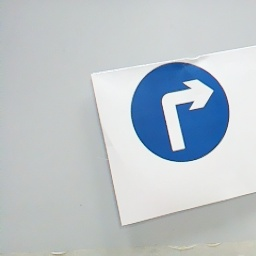
  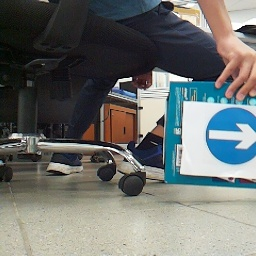
  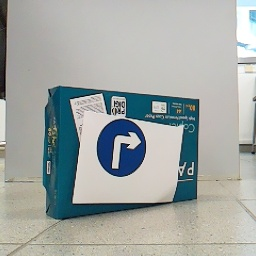


4. **Various Objects and Poses**
  
  The objects should be captured at different positions and orientations for more robust identification. Multiple objects of the same class can be captured.

5. **File Organization**

  Put all images in a folder `datasets/proj2/images/`. The `images` folder is in the `proj2` folder, which is in the `datasets` folder. The images should be in the `images` folder.


## 3.2 &emsp; Annotate Images
1. **Upload Images and Prepare Labels**
  1. Go to https://www.makesense.ai/
  2. Select `Get Started` at the bottom right.
  3. Upload all images from the `datasets/proj2/images/` folder.
  4. Click `Object Detection`.
  5. Create a label for each of your object class. **Remember the order which the labels are created**. The first object class will be assigned an integer `0`. The second is `1`, etc.
  6. Select `Start project`.
2. **Annotate**
  
  Begin the hour-long process of manual labelling, by drawing bounding boxes across the object in the image. Make sure that the correct label (object class) is chosen.

3. **Export and Save Annotations**
  1. Once done, go to the top-left corner, select `Actions`, and click `Export Annotations`.
  2. Select `A .zip package containing files in YOLO format`.
  3. Click `Export`.
  4. Open the downloaded `.zip` file, and extract all the `.txt` annotation files into the `datasets/proj2/labels` folder. Create the folder if required. You should now have the `images` and `labels` folder in the `datasets/proj2` folder.

## 3.3 &emsp; YOLO Configuration File
1. Create a `datasets.yaml` file (you can create a text file and save it as a `.yaml` file), or download the one provided in Canvas. The yaml file looks like this:
```yaml
  # relative to this file, the dataset is contained in `datasets/proj2/`
  # images are located in the `datasets/proj2/images/` folder.
  # labels are located in the `datasets/proj2/labels/` folder.

  path: proj2
  train: images/
  val: images/
  test: # (optional)

  # Classes
  names:
    0: class1
    1: class2
    2: class3
```
2. Replace `class1` etc. with appropriate names. Make sure that the integer to the left **correspond to the integers used during the annotation**.

3. Zip the `datasets.yaml` and the `datasets` folder in to a `datasets.zip` folder. Make sure that both are at the top level of the zip file. The hierarchiy is shown below:
  
  `datasets.zip`
  - `datasets.yaml`
  - `datasets/`
    - `images/`
    - `labels/`

## 3.4 &emsp; Upload `dataset.zip` and Unzip
Run the following to upload and unzip the `dataset.zip` on Colab.

In [ ]:
from google.colab import files

!rm -rf datasets.zip
files.upload_file('datasets.zip')
!rm -rf datasets/
!unzip datasets.zip

## 3.5 &emsp; Train Using YOLOv11 Pre-trained Model
Here, we take advantage of *transfer learning* to hasten the training process.
The code imports pre-trained weights from the YOLOv11 model and learns to identify our new objects from there.

**This will take between 1 to 2 hours to complete.**

In [ ]:
!pip install ultralytics  --no-deps
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="dataset.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=128,  # All images are automatically resized before training and predicting.
    device="cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

# Perform object detection on an image
#results = model("datasets/proj2/images/left0000.jpg")
#results[0].show()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 67.8MB/s]


Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=traffic_train.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=100, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/traffic/labels... 763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 763/763 [00:00<00:00, 1664.07it/s]

train: New cache created: /content/datasets/traffic/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/traffic/labels.cache... 763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 763/763 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.171      3.746     0.9532         14        128: 100%|██████████| 48/48 [00:28<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]

                   all        763        763    0.00884      0.468     0.0397     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G       1.08      2.242     0.8877         14        128: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]

                   all        763        763      0.577      0.101      0.448      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G     0.9795      1.589     0.8724         18        128: 100%|██████████| 48/48 [00:26<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.78it/s]

                   all        763        763      0.533      0.868      0.623      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G     0.9076      1.296     0.8865         18        128: 100%|██████████| 48/48 [00:26<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]

                   all        763        763      0.562      0.887      0.702      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.8885      1.128     0.8664         13        128: 100%|██████████| 48/48 [00:26<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]

                   all        763        763      0.686      0.829      0.824       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.8122     0.9863     0.8718         22        128: 100%|██████████| 48/48 [00:25<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.89it/s]

                   all        763        763      0.672      0.854      0.883      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.8384      0.954     0.8752         15        128: 100%|██████████| 48/48 [00:26<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]

                   all        763        763      0.702      0.895      0.901      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.7715     0.8358     0.8594         21        128: 100%|██████████| 48/48 [00:26<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]

                   all        763        763      0.907      0.933      0.953      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G       0.77     0.7821     0.8589         16        128: 100%|██████████| 48/48 [00:26<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.94it/s]

                   all        763        763      0.939      0.954      0.981      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.7525     0.7376     0.8604         18        128: 100%|██████████| 48/48 [00:26<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]

                   all        763        763      0.913      0.919      0.983      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.7428     0.7256      0.855         19        128: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]

                   all        763        763      0.978      0.973      0.992      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.7347     0.6991     0.8575         15        128: 100%|██████████| 48/48 [00:27<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]

                   all        763        763      0.935      0.952      0.982      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.7496     0.6866     0.8491         23        128: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.82it/s]

                   all        763        763       0.98      0.975      0.993      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.6802     0.6434      0.842         16        128: 100%|██████████| 48/48 [00:33<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]

                   all        763        763      0.962      0.969      0.986      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.7239      0.641     0.8514         18        128: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.78it/s]

                   all        763        763      0.967      0.966      0.992       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.7055     0.6561     0.8666         17        128: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.76it/s]

                   all        763        763      0.983      0.979      0.993      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      0.672     0.5735     0.8377         16        128: 100%|██████████| 48/48 [00:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]

                   all        763        763      0.982      0.986      0.994      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.6646     0.5671     0.8402         25        128: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]

                   all        763        763      0.963      0.966      0.989      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.7029     0.6012     0.8511         17        128: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]

                   all        763        763      0.962      0.976      0.992      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.6909     0.5812     0.8502         15        128: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]

                   all        763        763      0.989      0.996      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.6956     0.5644     0.8466         19        128: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]

                   all        763        763      0.989      0.991      0.995      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.6949     0.5687     0.8602         19        128: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.47it/s]

                   all        763        763      0.985      0.984      0.995      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.6588     0.5416     0.8468         16        128: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]

                   all        763        763      0.995      0.997      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G     0.6461     0.5305     0.8349         20        128: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.86it/s]

                   all        763        763      0.995      0.996      0.995      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.6445     0.5152     0.8335         14        128: 100%|██████████| 48/48 [00:28<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]

                   all        763        763      0.993      0.996      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G     0.6361     0.5212     0.8399         17        128: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]

                   all        763        763      0.996      0.997      0.995      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.6601     0.5244     0.8437         21        128: 100%|██████████| 48/48 [00:30<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]

                   all        763        763      0.996      0.992      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.6314      0.526     0.8386         19        128: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]

                   all        763        763      0.989      0.987      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.6292     0.4848     0.8403         13        128: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]

                   all        763        763      0.994      0.989      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.6246     0.4906     0.8498         20        128: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]

                   all        763        763       0.99      0.993      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      0.652     0.5229     0.8338         13        128: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]

                   all        763        763       0.99      0.996      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.6171     0.4768     0.8294         11        128: 100%|██████████| 48/48 [00:39<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]

                   all        763        763      0.997      0.998      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.6234     0.5002     0.8319         16        128: 100%|██████████| 48/48 [00:36<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.47it/s]

                   all        763        763      0.953      0.984      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      0.626     0.4854      0.834         11        128: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]

                   all        763        763      0.999      0.995      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.6221     0.4837      0.832         20        128: 100%|██████████| 48/48 [00:36<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]

                   all        763        763      0.998          1      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.6273     0.4624     0.8323         23        128: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]

                   all        763        763      0.995      0.992      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.6042     0.4531     0.8448         22        128: 100%|██████████| 48/48 [00:30<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.88it/s]

                   all        763        763      0.996          1      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.5889     0.4402     0.8404         20        128: 100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]

                   all        763        763      0.996      0.997      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.6109     0.4423       0.82         17        128: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]

                   all        763        763      0.999          1      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.6138     0.4452     0.8418         19        128: 100%|██████████| 48/48 [00:30<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]

                   all        763        763      0.995      0.999      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.6109     0.4666     0.8338         17        128: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.80it/s]

                   all        763        763      0.997      0.999      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.6021     0.4398     0.8319         21        128: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]

                   all        763        763      0.996      0.999      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.5821     0.4366     0.8265         20        128: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]

                   all        763        763      0.995      0.992      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.5877       0.46     0.8366         16        128: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.78it/s]

                   all        763        763      0.996      0.999      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.6125     0.4558      0.827         17        128: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.78it/s]

                   all        763        763      0.998          1      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.5814     0.4308     0.8247         17        128: 100%|██████████| 48/48 [00:26<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.87it/s]

                   all        763        763      0.997      0.997      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      0.572     0.4028     0.8196         20        128: 100%|██████████| 48/48 [00:29<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.49it/s]

                   all        763        763      0.997          1      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.6002     0.4137     0.8313         17        128: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.78it/s]

                   all        763        763      0.997      0.999      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.5566     0.4107     0.8239         20        128: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]

                   all        763        763      0.999          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.5662     0.4051     0.8259         23        128: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]

                   all        763        763      0.993      0.995      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.5723     0.4243      0.835         23        128: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

                   all        763        763      0.995      0.997      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.5617     0.4097     0.8271         17        128: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]

                   all        763        763      0.995      0.997      0.995      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.5821     0.4137     0.8343         15        128: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]

                   all        763        763      0.998          1      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.5805     0.4106     0.8286         15        128: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.67it/s]

                   all        763        763      0.997      0.998      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.5759     0.4114     0.8253         13        128: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]

                   all        763        763      0.997          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.5423     0.3799     0.8264         17        128: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]

                   all        763        763      0.998          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.5498      0.384     0.8243         26        128: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]

                   all        763        763      0.999          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.5211     0.3651     0.8125         18        128: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]

                   all        763        763      0.999          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.5289      0.372     0.8235         18        128: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]

                   all        763        763      0.999          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      0.532     0.3751     0.8318         26        128: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]

                   all        763        763      0.998          1      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.5571     0.3732     0.8311          9        128: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

                   all        763        763      0.999          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.5425     0.3797     0.8117         17        128: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

                   all        763        763      0.999          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.5368     0.3754     0.8248         17        128: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]

                   all        763        763      0.998          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.5271     0.3667     0.8229         17        128: 100%|██████████| 48/48 [00:36<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]

                   all        763        763      0.999          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.5349     0.3597     0.8285         12        128: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.46it/s]

                   all        763        763      0.999          1      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.5404     0.3719     0.8266         18        128: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]

                   all        763        763      0.998          1      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      0.515     0.3552     0.8245         17        128: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]

                   all        763        763      0.999          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.5289     0.3693     0.8215         18        128: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.82it/s]

                   all        763        763      0.999          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.5147     0.3703     0.8151         20        128: 100%|██████████| 48/48 [00:32<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

                   all        763        763      0.999      0.999      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.5343     0.3632     0.8213         21        128: 100%|██████████| 48/48 [00:30<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]

                   all        763        763      0.998          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.5276     0.3572     0.8251         18        128: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]

                   all        763        763      0.999      0.999      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.5174     0.3464      0.825         10        128: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]

                   all        763        763      0.999          1      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.5168     0.3492     0.8174         10        128: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.89it/s]

                   all        763        763      0.998          1      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.5063     0.3363     0.8102         17        128: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]

                   all        763        763      0.999          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.5193     0.3399     0.8217         16        128: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]

                   all        763        763      0.999          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.4941      0.349     0.8259         14        128: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.47it/s]

                   all        763        763      0.999          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.5205      0.346       0.81          9        128: 100%|██████████| 48/48 [00:30<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]

                   all        763        763      0.998          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.5133     0.3458     0.8173         18        128: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]

                   all        763        763      0.999          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.5022     0.3297     0.8221         10        128: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]

                   all        763        763      0.999          1      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.5054     0.3214     0.8221         14        128: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]

                   all        763        763      0.999          1      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.5004     0.3314     0.8275         14        128: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]

                   all        763        763      0.998      0.999      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.4807     0.3266     0.8181         14        128: 100%|██████████| 48/48 [00:29<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.89it/s]

                   all        763        763      0.999      0.998      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.4991     0.3199     0.8102         14        128: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.90it/s]

                   all        763        763      0.999          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.4934     0.3171      0.813         19        128: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]

                   all        763        763      0.999          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.5107     0.3189     0.8152         15        128: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.94it/s]

                   all        763        763      0.998          1      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.4712     0.3204     0.8259         17        128: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.87it/s]

                   all        763        763      0.998          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.4842      0.312     0.8137         22        128: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]

                   all        763        763      0.999          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.4789     0.3193     0.8203         14        128: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]

                   all        763        763      0.999          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.4617     0.3138     0.8157         23        128: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

                   all        763        763      0.998          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.4817      0.313     0.8184         16        128: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]

                   all        763        763      0.999          1      0.995      0.915


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.4497     0.2898     0.7978         11        128: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.89it/s]

                   all        763        763      0.998          1      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.4337     0.2774     0.7965         10        128: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]

                   all        763        763      0.998          1      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.4435      0.279     0.7894         11        128: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]

                   all        763        763      0.999      0.999      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.4387     0.2758     0.7912         11        128: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]

                   all        763        763      0.999      0.999      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.4297     0.2691     0.7763         11        128: 100%|██████████| 48/48 [00:28<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.71it/s]

                   all        763        763      0.999      0.999      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.4244     0.2692     0.7882         11        128: 100%|██████████| 48/48 [00:26<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]

                   all        763        763      0.998          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.4287     0.2649     0.7916         11        128: 100%|██████████| 48/48 [00:26<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.62it/s]

                   all        763        763      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.4259     0.2639     0.7858         11        128: 100%|██████████| 48/48 [00:30<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.76it/s]

                   all        763        763      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.4154     0.2572     0.7893         11        128: 100%|██████████| 48/48 [00:26<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]

                   all        763        763      0.999          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.4213     0.2616     0.7968         11        128: 100%|██████████| 48/48 [00:26<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]

                   all        763        763      0.999          1      0.995      0.924



100 epochs completed in 1.257 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.90it/s]


                   all        763        763      0.999          1      0.995      0.925
                  stop        120        120      0.998          1      0.995      0.906
                  left        245        245          1          1      0.995      0.914
                 right        182        182      0.999          1      0.995      0.929
            accelerate        121        121      0.999          1      0.995      0.932
           deccelerate         95         95      0.998          1      0.995      0.945
Speed: 0.2ms preprocess, 13.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients


val: Scanning /content/datasets/traffic/labels.cache... 763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 763/763 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:12<00:00,  3.92it/s]


                   all        763        763      0.999          1      0.995      0.925
                  stop        120        120      0.998          1      0.995      0.906
                  left        245        245          1          1      0.995      0.914
                 right        182        182      0.999          1      0.995      0.929
            accelerate        121        121      0.999          1      0.995      0.932
           deccelerate         95         95      0.998          1      0.995      0.945
Speed: 0.1ms preprocess, 12.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train2
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 128, 128) BCHW and output shape(s) (1, 9, 336) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━

## 3.6 &emsp; Download Trained Model
Download the trained model `best.pt`.

In [ ]:
!cp runs/detect/train/weights/best.pt best.pt
files.download('runs/detect/train/weights/best.pt')

## 3.7 &emsp; Record 30s Video and Demonstrate Model
A lab computer can be borrowed for this task. Please approach the TA / GA / Lecturer for this. The lab computer contains the `yolo_test.py` script which can be run.

1. **Record 30s `in.mp4` Video**
  
  1. Record a 30s video containing all of the objects. Keep the resolution and file size small (640px by 480px) so it is faster to move it and process.
  2. Label this video `in.mp4`.
  3. Put the video in an appropriate folder in your computer.

2. **Make `yolo_test.py`**

  1. Install `ultralytics` in your computer with:
    ```bash
    pip install ultralytics
    ```

  2. Create a script called `yolo_test.py` containing the following code, and place it in the same folder as `in.mp4`.

```python
# yolo_test.py
import cv2
import numpy as np
from ultralytics import YOLO

model = YOLO("best.pt")
cap = cv2.VideoCapture('in.mp4')

if (cap.isOpened()== False):
  print("Error opening video stream or file")

imgs = []
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    img = cv2.imread('Frame',frame)
    results = model(img)
    numpy_result = results[0].cpu().numpy()
    # print(numpy_result.boxes.xyxy)
    if len(numpy_result.boxes.xyxy) > 0:
      for box in range(len(numpy_result.boxes.xyxy)):
        x1 = int(numpy_result.boxes.xyxy[box][0])
        y1 = int(numpy_result.boxes.xyxy[box][1])
        x2 = int(numpy_result.boxes.xyxy[box][2])
        y2 = int(numpy_result.boxes.xyxy[box][3])
        imgs.append(cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,255), 2))
      
  else:
    break
cap.release()

print('writing to video...')
if imgs:
  height, width, layers = img.shape
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter('out.mp4', fourcc, 30, (width,height))
  for img in imgs:
    video.write(img)
  video.release()

cv2.destroyAllWindows()
```
3. **Place Trained Model `best.pt`**
  
  Place `best.pt` in the same folder as the files above.

4. **Generate `out.mp4`**

  Open a terminal and *change directory* to the folder where the folders are stored. Then, run the following to see the results
  ```bash
  python3 yolo_test.py
  ```
  
  **If you have trouble running**, an appropriate version of `numpy` may have to be installed. You can install an appropriate version with
  ```bash
  pip install --upgrade numpy==1.26
  ```

5. Use the generated `out.mp4` as your demonstration video. Depending on the codec used, the video may drop some frames.
